Data:
- CDS EURO-CORDEX climatic data for 2m air temperature 2026-2041 ... 2100? and instrumental preiod 2016-2020 (11km spatial; 1day temporal) ### CDS API
####
- CDS EURO-CORDEX Heat-wave projections rcp 4.5 rcp 8.5 (11km) ### https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=form
####
- CDS Climate variables for cities (only for bigger EU cities, NOT for the EU) (100m) in Europe from 2008 to 2017 ### https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-urban-climate-cities?tab=overview
####
- SENTINEL2 data for Vegetation characteristics (10-20m spatial; 5-10 days temporal) (NDVI, NDWI, LAI, NDDI, NDBI) ### https://dataspace.copernicus.eu/browser/?zoom=3&lat=26&lng=0&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2Fa91f72b5-f393-4320-bc0f-990129bd9e63&datasetId=S2_L2A_CDAS&demSource3D=%22MAPZEN%22&cloudCoverage=30
####
- LANDSAT8 land surface temperature for the 2016-2020 (15-30m spatial; 8-16 days tremporal) ### https://rslab.gr/downloads_LandsatLST.html
####
- CHELSA climatic data downscaled from CMIP6 (1km spatial; monthly values, daily values are not available) ### https://envicloud.wsl.ch/#/?prefix=chelsa%2Fchelsa_V2%2FGLOBAL%2F ### https://chelsa-climate.org/
####

Process:
1. LANDSAT8 (30m) for the identification of the overheated areas.
####
2. SENTINEL2 for the computation of the Vegetation characteristics, find places suitable for the green measures NDVI, NDWI,
NDDI, NDBI (done)
####
3. EURO-CORDEX data for the Heat-wave events. The data from Euro-Corex are already precalculated for specific cities in EU.
####
4. CHELSA data for the Heat-Wave events extraction. We need the daily data (we need to ask for data, and there is the problem with the data volume to store) or precalculated Heat-waves.  
####
5. CRITICAL INFRASTRUCTURE data from Zilina. For example if the critical areas are in the most populated areas. 

Future steps:
1. Automatization of the data downloading processes.

2. Make a data storage (Cloud ...) for data.

3. Ask the Chelsa creators for cooperation.

4. Agree for the common metodology for heat-wave extraction (PesetaIV,Thermofeel ....)


# Import packages

If there be some problems with the instalation of the packages, please let me know. I experience difficulties with the cartopy package. 

In [1]:
import zipfile        # working with the zip folders #
import os             # handling the current working directory
import rasterio       # netcdf and raster processing  #
from pathlib import Path # file system paths
import rioxarray as rxr # netcdf and raster processing
#import leafmap
#import leafmap.colormaps as cm
import cdsapi         # API downloading
import numpy as np    # 2-3D array data handling
import pandas as pd   # data handling #
import xarray as xr   # 2-3D array data handling 
#import geopandas as gpd
from osgeo import gdal # Geo data handling 
#import cordex as cx
import cartopy.crs as ccrs # netcdf data projection 
import cartopy.feature as cf # netcdf data projection 
import cartopy.crs as ccrs # netcdf data projection 
import matplotlib as mpl  #  data plot #
import matplotlib.pyplot as plt #  data plot #
from rasterio.crs import CRS  #  raster dat handling 
from pylab import pcolormesh,show,colorbar,plot,title,legend,subplot,savefig
from xrspatial.classify import reclassify
from matplotlib import pyplot
from rasterio.plot import show
from glob import glob
import geopandas as gpd
import rasterio as rio
#from pathlib import Path

# Downloading of the Euro-Cordex data (API) 

Manual for the use of the CDS API: https://cds.climate.copernicus.eu/api-how-to

In [ ]:
# Change KEY!!!
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "152800:1c6ca43d-189d-48d1-9bef-b571c3f35f34"
c = cdsapi.Client(url=URL, key=KEY)


DATADIR = 'C:\Work\KAJO\CLIMAAX\GitHub\Data_'
data = c.retrieve(
    "projections-cordex-domains-single-levels",
    {
           "domain": "europe",
           "experiment": "rcp_8_5",
           "horizontal_resolution": "0_11_degree_x_0_11_degree",
           "temporal_resolution": "daily_mean",
           "variable": [
               "2m_air_temperature", "maximum_2m_temperature_in_the_last_24_hours", "minimum_2m_temperature_in_the_last_24_hours",
           ],
           "gcm_model": "cnrm_cerfacs_cm5",
           "rcm_model": "clmcom_clm_cclm4_8_17",
           "ensemble_member": "r1i1p1",
            "start_year": [
                "2023", "2024", "2025","2026", "2027", "2028", "2029", "2030", "2031", "2032", "2033", "2034", "2035",
                "2026", "2027", "2028","2029", "2030", "2031", "2032", "2033", "2034", "2035", "2036", "2037", "2038",
                "2039", "2040",
            ],
            "end_year": [
                "2023", "2024", "2025","2026", "2027", "2028", "2029", "2030", "2031", "2032", "2033", "2034", "2035",
                "2026", "2027", "2028","2029", "2030", "2031", "2032", "2033", "2034", "2035", "2036", "2037", "2038",
                "2039", "2040",
            ],
           "format": "zip",
    },
   f"{DATADIR}era5_daily_t2m_eurminmax_2040.zip")

# Load of the Euro-Cordex daily mean data 

Downloaded data are in the 5 year step. For the load of the data we need to select the directory and then start computing:
1. Load the data for 3 five years periods, then merge it to 2026-2040
2. Convert the unit from K to C 
3. Calculate the monthly means values
4. Set CRS to rotated pole 
5. Save the data on the disk

In [2]:
# Change directories!!!
t1m='C:/Work/KAJO/CLIMAAX/GitHub/era5_daily_t2m_eurminmax_2040/tas_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20260101-20301231.nc'
t2m='C:/Work/KAJO/CLIMAAX/GitHub/era5_daily_t2m_eurminmax_2040/tas_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20310101-20351231.nc'
t3m='C:/Work/KAJO/CLIMAAX/GitHub/era5_daily_t2m_eurminmax_2040/tas_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20360101-20401231.nc'

dm = xr.open_dataset(t1m)

# in case we want to work with 15 years  
#dm2 = xr.open_dataset(t2m)
#dm3 = xr.open_dataset(t3m)

In [ ]:
# in case we want to work with 15 years 
#dm=xr.merge((dm, dm2, dm3))

In [3]:
dm=xr.decode_cf(dm,decode_coords="all") # without decoding of the coordinates it is not working !!!
dm

<xarray.Dataset>
Dimensions:                     (time: 1826, bnds: 2, rlat: 412, rlon: 424,
                                 vertices: 4)
Coordinates:
  * time                        (time) datetime64[ns] 2026-01-01T12:00:00 ......
    time_bnds                   (time, bnds) datetime64[ns] ...
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    lat_vertices                (rlat, rlon, vertices) float32 ...
    lon_vertices                (rlat, rlon, vertices) float32 ...
    height                      float64 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    tas                         (time, rlat, rlon) float32 ...
Attributes: (12/30)
    institution:                    Climate Limited-area Modelling Community ...
    institute_id:                   CLMcom
    experiment_id:                  rcp85
    source:                         CLMcom-CCLM4-8-17
    model_id:                       CLMcom-CCLM4-8-17
    contact:                        cordex-cclm@dkrz.de
    ...                             ...
    table_id:                       Table day (Sept 2013) 0cf1782745489246c9f...
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/9f306000-790a-446e-8d1f-76db...
    c3s_disclaimer:                 This data has been produced in the contex...

#### Convert from K to °C, and computing of the monthly mean values 

In [4]:
da_m=dm['tas']
tas=da_m -273.15
tas=tas.assign_attrs(da_m.attrs)
tas.attrs['units']='°C'
monthly_mean = tas.groupby('time.month').mean(keep_attrs=True)
#monthly_mean[0,:,:].plot()

In [5]:
#monthly_mean=xr.decode_cf(monthly_mean, decode_coords="all")
monthly_mean

<xarray.DataArray 'tas' (month: 12, rlat: 412, rlon: 424)>
array([[[ 18.689358 ,  18.656395 ,  18.652124 , ...,  22.184233 ,
          22.261993 ,  22.362082 ],
        [ 18.344263 ,  18.162819 ,  18.124533 , ...,  22.028849 ,
          22.137817 ,  22.291426 ],
        [ 18.091661 ,  17.8109   ,  17.59354  , ...,  21.911816 ,
          22.078163 ,  22.236439 ],
        ...,
        [ -6.9445863,  -7.3259583,  -7.9281945, ..., -23.320347 ,
         -23.9568   , -23.320078 ],
        [ -7.244194 ,  -7.5712986,  -7.74807  , ..., -23.402594 ,
         -24.196537 , -23.527267 ],
        [ -7.520491 ,  -7.315702 ,  -7.0076466, ..., -23.432201 ,
         -24.230501 , -23.940615 ]],

       [[ 19.968006 ,  19.980495 ,  20.002232 , ...,  22.175585 ,
          22.239286 ,  22.334843 ],
        [ 19.744633 ,  19.676453 ,  19.687744 , ...,  22.007463 ,
          22.108652 ,  22.26838  ],
        [ 19.564121 ,  19.429214 ,  19.334963 , ...,  21.880201 ,
          22.049007 ,  22.22394  ],
...
        [ -1.5482782,  -1.9330772,  -1.8229929, ..., -15.073288 ,
         -14.966668 , -14.196696 ],
        [ -2.0418305,  -2.0163777,  -1.6403679, ..., -15.24028  ,
         -15.288093 , -14.445047 ],
        [ -2.2393596,  -1.850809 ,  -0.9979539, ..., -14.9528055,
         -15.465908 , -14.900895 ]],

       [[ 19.303625 ,  19.256807 ,  19.248121 , ...,  23.691668 ,
          23.755438 ,  23.84419  ],
        [ 18.952705 ,  18.760303 ,  18.711885 , ...,  23.540712 ,
          23.637009 ,  23.76364  ],
        [ 18.693815 ,  18.394844 ,  18.163448 , ...,  23.421633 ,
          23.56588  ,  23.695082 ],
        ...,
        [ -4.4992614,  -4.9212103,  -5.0655737, ..., -18.217943 ,
         -18.408787 , -18.064512 ],
        [ -5.0250716,  -4.9935155,  -4.6486216, ..., -18.2937   ,
         -18.851265 , -18.132872 ],
        [ -5.1080337,  -4.7263103,  -3.9593985, ..., -18.363785 ,
         -19.08774  , -18.571554 ]]], dtype=float32)
Coordinates:
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
  * month                       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    comment:           daily-mean near-surface (usually, 2 meter) air tempera...
    units:             °C
    cell_methods:      time: mean
    associated_files:  gridspecFile: gridspec_atmos_fx_CLMcom-CCLM4-8-17_rcp8...

Text(0.5, 1.0, 'T monthly mean projection for specific month')

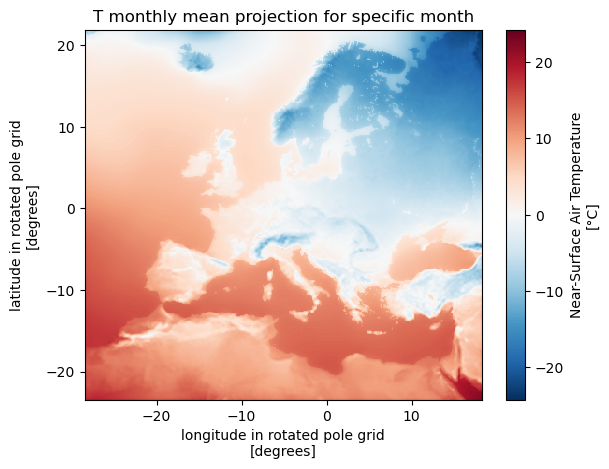

In [12]:
monthly_mean[0,:,:].plot()
plt.title('T monthly mean projection for specific month') 

#### Setting of the CRS for Euro-Cordex rotated pole and save 

For crs setting we use the cartopy package, with this crs it is usable in any GIS software with WGS84

In [7]:
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)

In [8]:
monthly_mean.rio.write_crs(rotated_pole, inplace=True)

<xarray.DataArray 'tas' (month: 12, rlat: 412, rlon: 424)>
array([[[ 18.689358 ,  18.656395 ,  18.652124 , ...,  22.184233 ,
          22.261993 ,  22.362082 ],
        [ 18.344263 ,  18.162819 ,  18.124533 , ...,  22.028849 ,
          22.137817 ,  22.291426 ],
        [ 18.091661 ,  17.8109   ,  17.59354  , ...,  21.911816 ,
          22.078163 ,  22.236439 ],
        ...,
        [ -6.9445863,  -7.3259583,  -7.9281945, ..., -23.320347 ,
         -23.9568   , -23.320078 ],
        [ -7.244194 ,  -7.5712986,  -7.74807  , ..., -23.402594 ,
         -24.196537 , -23.527267 ],
        [ -7.520491 ,  -7.315702 ,  -7.0076466, ..., -23.432201 ,
         -24.230501 , -23.940615 ]],

       [[ 19.968006 ,  19.980495 ,  20.002232 , ...,  22.175585 ,
          22.239286 ,  22.334843 ],
        [ 19.744633 ,  19.676453 ,  19.687744 , ...,  22.007463 ,
          22.108652 ,  22.26838  ],
        [ 19.564121 ,  19.429214 ,  19.334963 , ...,  21.880201 ,
          22.049007 ,  22.22394  ],
...
        [ -1.5482782,  -1.9330772,  -1.8229929, ..., -15.073288 ,
         -14.966668 , -14.196696 ],
        [ -2.0418305,  -2.0163777,  -1.6403679, ..., -15.24028  ,
         -15.288093 , -14.445047 ],
        [ -2.2393596,  -1.850809 ,  -0.9979539, ..., -14.9528055,
         -15.465908 , -14.900895 ]],

       [[ 19.303625 ,  19.256807 ,  19.248121 , ...,  23.691668 ,
          23.755438 ,  23.84419  ],
        [ 18.952705 ,  18.760303 ,  18.711885 , ...,  23.540712 ,
          23.637009 ,  23.76364  ],
        [ 18.693815 ,  18.394844 ,  18.163448 , ...,  23.421633 ,
          23.56588  ,  23.695082 ],
        ...,
        [ -4.4992614,  -4.9212103,  -5.0655737, ..., -18.217943 ,
         -18.408787 , -18.064512 ],
        [ -5.0250716,  -4.9935155,  -4.6486216, ..., -18.2937   ,
         -18.851265 , -18.132872 ],
        [ -5.1080337,  -4.7263103,  -3.9593985, ..., -18.363785 ,
         -19.08774  , -18.571554 ]]], dtype=float32)
Coordinates:
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
  * month                       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref                 int32 0
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    comment:           daily-mean near-surface (usually, 2 meter) air tempera...
    units:             °C
    cell_methods:      time: mean
    associated_files:  gridspecFile: gridspec_atmos_fx_CLMcom-CCLM4-8-17_rcp8...

In [ ]:
monthly_mean.to_netcdf(path='C:/Work/KAJO/CLIMAAX/GitHub/EC_monthly_mean.nc', mode='w', format='NETCDF4')

# Euro-Cordex T max for Heat-Wave   

For The heat-wave we use the daily maximum temperature. 
1. Load the data, then merge it to 2026-2040
2. Convert the unit from K to C
3. Calculate the maximum monthly means values
4. Set CRS to rotated pole
5. Save the data on the disk
6. Divide data to months = preparation for the Heat-wave segregation
7. Clip data to pilot site

In [9]:
# Change directories!!!
t1max='C:/Work/KAJO/CLIMAAX/GitHub/era5_daily_t2m_eurminmax_2040/tasmax_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20260101-20301231.nc'
t2max='C:/Work/KAJO/CLIMAAX/GitHub/era5_daily_t2m_eurminmax_2040/tasmax_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20310101-20351231.nc'
t3max='C:/Work/KAJO/CLIMAAX/GitHub/era5_daily_t2m_eurminmax_2040/tasmax_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20360101-20401231.nc'

d = xr.open_dataset(t1max)

# if we want 15 years 
#d2 = xr.open_dataset(t2max)
#d3 = xr.open_dataset(t3max)

In [ ]:
# if we want 15 years 
#d=xr.merge((d,d2,d3))

In [10]:
d=xr.decode_cf(d, decode_coords="all")

Text(0.5, 1.0, 'T monthly mean projection for specific month')

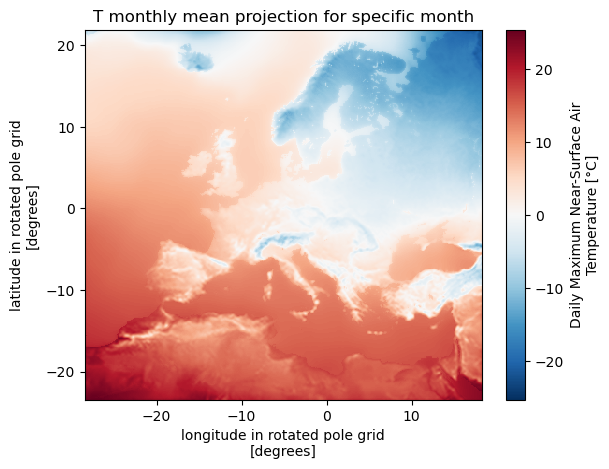

In [13]:
dmax=d['tasmax']
tasmax=dmax - 273.15
tasmax=tasmax.assign_attrs(dmax.attrs)
tasmax.attrs['units']='°C'
max_monthly_mean = tasmax.groupby('time.month').mean(keep_attrs=True)
max_monthly_mean[0,:,:].plot()
plt.title('T monthly mean projection for specific month')

In [ ]:
#tasmax

#### Setting of the CRS

In [14]:
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)

In [15]:
max_monthly_mean.rio.write_crs(rotated_pole, inplace=True)

<xarray.DataArray 'tasmax' (month: 12, rlat: 412, rlon: 424)>
array([[[ 24.876232  ,  24.908596  ,  24.947838  , ...,  23.112467  ,
          23.185183  ,  23.27103   ],
        [ 24.731739  ,  24.752745  ,  24.79064   , ...,  23.006758  ,
          23.103746  ,  23.232784  ],
        [ 24.532879  ,  24.531553  ,  24.56547   , ...,  22.941364  ,
          23.087547  ,  23.220926  ],
        ...,
        [ -5.7670126 ,  -6.0332932 ,  -6.208386  , ..., -21.719362  ,
         -22.272062  , -21.726341  ],
        [ -6.0980077 ,  -6.175007  ,  -6.0897713 , ..., -21.794067  ,
         -22.540487  , -21.91034   ],
        [ -6.403774  ,  -6.0944595 ,  -5.548317  , ..., -21.852602  ,
         -22.668615  , -22.317709  ]],

       [[ 26.12137   ,  26.1823    ,  26.243622  , ...,  23.164322  ,
          23.20636   ,  23.270555  ],
        [ 26.115099  ,  26.202852  ,  26.269156  , ...,  23.047628  ,
          23.117271  ,  23.229996  ],
        [ 26.089796  ,  26.202135  ,  26.325655  , ...,  22.958805  ,
          23.082518  ,  23.210459  ],
...
        [ -0.42691588,  -0.7219847 ,  -0.5220168 , ..., -13.399757  ,
         -13.243869  , -12.549541  ],
        [ -0.8646468 ,  -0.78848064,  -0.35057983, ..., -13.57725   ,
         -13.620438  , -12.830848  ],
        [ -1.1339816 ,  -0.7345587 ,   0.19439961, ..., -13.326763  ,
         -13.818131  , -13.286027  ]],

       [[ 25.273306  ,  25.29351   ,  25.324293  , ...,  24.594578  ,
          24.668846  ,  24.768925  ],
        [ 25.068064  ,  25.06764   ,  25.090614  , ...,  24.499016  ,
          24.596151  ,  24.733128  ],
        [ 24.843533  ,  24.80432   ,  24.80693   , ...,  24.440525  ,
          24.56337   ,  24.706648  ],
        ...,
        [ -3.311518  ,  -3.6335075 ,  -3.5244846 , ..., -16.39258   ,
         -16.543457  , -16.243048  ],
        [ -3.7490082 ,  -3.626877  ,  -3.126487  , ..., -16.474747  ,
         -16.932884  , -16.340483  ],
        [ -3.8592994 ,  -3.4443524 ,  -2.625984  , ..., -16.508099  ,
         -17.154072  , -16.735064  ]]], dtype=float32)
Coordinates:
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
  * month                       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref                 int32 0
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    comment:           daily-maximum near-surface (usually, 2 meter) air temp...
    units:             °C
    cell_methods:      time: maximum
    history:           2014-03-26T13:11:29Z altered by CMOR: Treated scalar d...
    associated_files:  gridspecFile: gridspec_atmos_fx_CLMcom-CCLM4-8-17_rcp8...

In [ ]:
max_monthly_mean.to_netcdf(path='C:/Work/KAJO/CLIMAAX/GitHub/max_monthly_mean_EU.nc', mode='w', format='NETCDF4')

#### Didive data to the months  

In [16]:
# Use .groupby('time.month') to organize the data into months
# then use .groups to extract the indices for each month
tasmax_month=tasmax.groupby('time.month').groups

# Extract the time indices corresponding to all the Januarys 
jan_idxs=tasmax_month[1]
feb_idxs=tasmax_month[2]
mar_idxs=tasmax_month[3]
apr_idxs=tasmax_month[4]
may_idxs=tasmax_month[5]
jun_idxs=tasmax_month[6]
jul_idxs=tasmax_month[7]
aug_idxs=tasmax_month[8]
sep_idxs=tasmax_month[9]
oct_idxs=tasmax_month[10]
nov_idxs=tasmax_month[11]
dec_idxs=tasmax_month[12]

# Extract the january months by selecting 
# the relevant indices
jan_max=tasmax.isel(time=jan_idxs)
feb_max=tasmax.isel(time=feb_idxs)
mar_max=tasmax.isel(time=mar_idxs)
apr_max=tasmax.isel(time=apr_idxs)
may_max=tasmax.isel(time=may_idxs)
jun_max=tasmax.isel(time=jun_idxs)
jul_max=tasmax.isel(time=jul_idxs)
aug_max=tasmax.isel(time=aug_idxs)
sep_max=tasmax.isel(time=sep_idxs)
oct_max=tasmax.isel(time=oct_idxs)
nov_max=tasmax.isel(time=nov_idxs)
dec_max=tasmax.isel(time=dec_idxs)

#### Setting of th CRS 

In [17]:
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)

In [18]:
jan_max.rio.write_crs(rotated_pole, inplace=True)
feb_max.rio.write_crs(rotated_pole, inplace=True)
mar_max.rio.write_crs(rotated_pole, inplace=True)
apr_max.rio.write_crs(rotated_pole, inplace=True)
may_max.rio.write_crs(rotated_pole, inplace=True)
jun_max.rio.write_crs(rotated_pole, inplace=True)
jul_max.rio.write_crs(rotated_pole, inplace=True)
aug_max.rio.write_crs(rotated_pole, inplace=True)
sep_max.rio.write_crs(rotated_pole, inplace=True)
oct_max.rio.write_crs(rotated_pole, inplace=True)
nov_max.rio.write_crs(rotated_pole, inplace=True)
dec_max.rio.write_crs(rotated_pole, inplace=True)
#jul_max.to_netcdf(path='C:/Work/KAJO/CLIMAAX/GitHub/EC_jul_max.nc', mode='w', format='NETCDF4')
#jul_max[0,:,:].plot()

<xarray.DataArray 'tasmax' (time: 155, rlat: 412, rlon: 424)>
array([[[ 2.5519684e+01,  2.5535370e+01,  2.5560181e+01, ...,
          2.7080017e+01,  2.7242584e+01,  2.7417755e+01],
        [ 2.5352386e+01,  2.5366119e+01,  2.5387329e+01, ...,
          2.6964233e+01,  2.7174896e+01,  2.7389343e+01],
        [ 2.5102783e+01,  2.5061798e+01,  2.5060974e+01, ...,
          2.6888062e+01,  2.7147675e+01,  2.7359680e+01],
        ...,
        [-1.7039185e+00, -1.7157593e+00, -1.0723572e+00, ...,
         -8.1273193e+00, -6.9174194e+00, -6.0684509e+00],
        [-1.9319763e+00, -1.5747681e+00, -7.5332642e-01, ...,
         -7.6708679e+00, -6.7821350e+00, -6.2133179e+00],
        [-2.1082153e+00, -1.4781494e+00,  2.8198242e-02, ...,
         -6.7959290e+00, -6.5736389e+00, -5.7239380e+00]],

       [[ 2.5682068e+01,  2.5684204e+01,  2.5701141e+01, ...,
          2.6663727e+01,  2.6939972e+01,  2.7288086e+01],
        [ 2.5669342e+01,  2.5676392e+01,  2.5681213e+01, ...,
          2.6555389e+01,  2.6907501e+01,  2.7294006e+01],
        [ 2.5615173e+01,  2.5630981e+01,  2.5680267e+01, ...,
          2.6520294e+01,  2.6953552e+01,  2.7291504e+01],
...
        [-9.2211914e-01, -1.0971375e+00, -6.0296631e-01, ...,
         -1.2823608e+01, -1.3538940e+01, -1.3381317e+01],
        [-1.2240601e+00, -1.0096741e+00, -1.7761230e-01, ...,
         -1.3083801e+01, -1.4907166e+01, -1.3664764e+01],
        [-1.6204224e+00, -1.1155701e+00,  8.9904785e-02, ...,
         -1.3431061e+01, -1.4211792e+01, -1.4194458e+01]],

       [[ 2.7132599e+01,  2.7134644e+01,  2.7148712e+01, ...,
          2.2364227e+01,  2.2432770e+01,  2.2582031e+01],
        [ 2.6797394e+01,  2.6760193e+01,  2.6756348e+01, ...,
          2.2272949e+01,  2.2377197e+01,  2.2612366e+01],
        [ 2.6384399e+01,  2.6235718e+01,  2.6164185e+01, ...,
          2.2231079e+01,  2.2372009e+01,  2.2675415e+01],
        ...,
        [-1.0381165e+00, -1.2444458e+00, -8.3996582e-01, ...,
         -1.2742035e+01, -1.2719360e+01, -1.2186920e+01],
        [-1.3425293e+00, -1.1119995e+00, -2.8421021e-01, ...,
         -1.3298889e+01, -1.3368225e+01, -1.2664825e+01],
        [-1.6441345e+00, -9.6032715e-01,  5.6558228e-01, ...,
         -1.3371765e+01, -1.3984711e+01, -1.3356720e+01]]], dtype=float32)
Coordinates:
  * time                        (time) datetime64[ns] 2026-12-01T12:00:00 ......
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
    spatial_ref                 int32 0
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    comment:           daily-maximum near-surface (usually, 2 meter) air temp...
    units:             °C
    cell_methods:      time: maximum
    history:           2014-03-26T13:11:29Z altered by CMOR: Treated scalar d...
    associated_files:  gridspecFile: gridspec_atmos_fx_CLMcom-CCLM4-8-17_rcp8...

#### Clip data to pilot site

In [ ]:
# Clip data to Slovakia 
jul_maxSK = jul_max.rio.clip_box(minx=-2, miny=-4, maxx=2, maxy=0,)

In [ ]:
jul_maxSK.rio.write_crs(rotated_pole, inplace=True)
jul_maxSK.to_netcdf(path='C:/Work/KAJO/CLIMAAX/GitHub/EC_jul_maxSK.nc', mode='w', format='NETCDF4')
jul_maxSK[1,:,:].plot()

In [19]:
tasmax.rio.write_crs(rotated_pole, inplace=True)
# Clip data to Zilina for 2026-2040
tasmaxZA = tasmax.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
# Clip data to Zilina for specific month 
jan_maxZA = jan_max.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
feb_maxZA = feb_max.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
mar_maxZA = mar_max.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
apr_maxZA = apr_max.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
may_maxZA = may_max.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
jun_maxZA = jun_max.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
jul_maxZA = jul_max.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
aug_maxZA = aug_max.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
sep_maxZA = sep_max.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
oct_maxZA = oct_max.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
nov_maxZA = nov_max.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
dec_maxZA = dec_max.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)

# For the Heat-wave segregation we used the 90 percentile

We used the methodology from the PESETA IV project https://joint-research-centre.ec.europa.eu/peseta-projects/jrc-peseta-iv_en

The HWMId is defined as the maximum magnitude of heat waves in a year. Specifically, a heat wave is defined as a period ≥ 3 consecutive days with maximum temperature above a daily threshold calculated for a 30-year-long reference period. At least 30-year time series of daily vales are needed to obtain a robust estimation of the indicator. The threshold is defined as the 90th percentile of daily maxima temperature, centred on a 31-day window. Hence, for a given day d, the threshold is the 90th percentile of the set of data Ad defined by


In [20]:
# 90 quantile for EU
julq90=jul_max.quantile(0.9, dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
# 90 quantile for ZA in period 2026-2040
tas90maxZA=tasmaxZA.quantile(0.9, dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
# 90 quantile for ZA for specific month
janq90_maxZA=jan_maxZA.quantile(0.9,dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
febq90_maxZA=feb_maxZA.quantile(0.9,dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
marq90_maxZA=mar_maxZA.quantile(0.9,dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
aprq90_maxZA=apr_maxZA.quantile(0.9,dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
mayq90_maxZA=may_maxZA.quantile(0.9,dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
junq90_maxZA=jun_maxZA.quantile(0.9,dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
julq90_maxZA=jul_maxZA.quantile(0.9,dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
augq90_maxZA=aug_maxZA.quantile(0.9,dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
sepq90_maxZA=sep_maxZA.quantile(0.9,dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
octq90_maxZA=oct_maxZA.quantile(0.9,dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
nowq90_maxZA=nov_maxZA.quantile(0.9,dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)
decq90_maxZA=dec_maxZA.quantile(0.9,dim=None, method='linear', keep_attrs=None, skipna=None, interpolation=None)

In [21]:
# 90 condition for EU
heatjul=xr.where(jul_max>julq90, 1, 0)
# 90 condition for ZA in period 2026-2040
heatZA=xr.where(tasmaxZA>tas90maxZA, 1, 0)
# 90 condition for ZA
heatjanZA=xr.where(jan_maxZA>julq90_maxZA, 1, 0)
heatfebZA=xr.where(feb_maxZA>julq90_maxZA, 1, 0)
heatmarZA=xr.where(mar_maxZA>julq90_maxZA, 1, 0)
heataprZA=xr.where(apr_maxZA>julq90_maxZA, 1, 0)
heatmayZA=xr.where(may_maxZA>julq90_maxZA, 1, 0)
heatjunZA=xr.where(jun_maxZA>julq90_maxZA, 1, 0)
heatjulZA=xr.where(jul_maxZA>julq90_maxZA, 1, 0)
heataugZA=xr.where(aug_maxZA>julq90_maxZA, 1, 0)
heatsepZA=xr.where(sep_maxZA>julq90_maxZA, 1, 0)
heatoctZA=xr.where(oct_maxZA>julq90_maxZA, 1, 0)
heatnovZA=xr.where(nov_maxZA>julq90_maxZA, 1, 0)
heatdecZA=xr.where(dec_maxZA>julq90_maxZA, 1, 0)
# Zilina treshold for EU 
heatjulZAEU=xr.where(jul_max>julq90_maxZA, 1, 0)

#### WRITE ON THE DISK for ZILINA the number of days exceeding the 90 percentile

Text(0.5, 1.0, 'Pixels which exceeded 90 percentile for specific day')

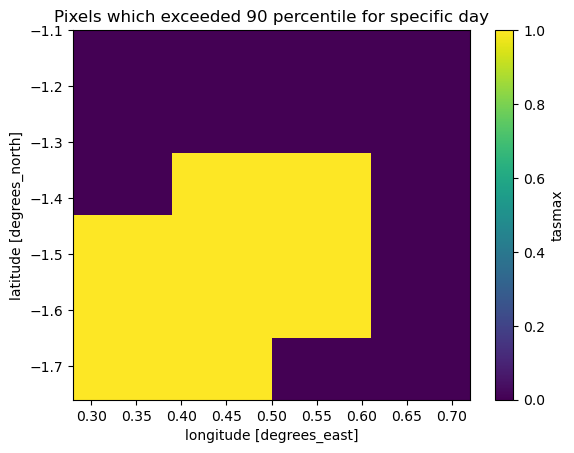

In [22]:
heatjulZA.rio.write_crs(rotated_pole, inplace=True)
#heatjulZA.to_netcdf(path='C:/Work/KAJO/CLIMAAX/GitHub/EC7_heatjulZA26_30.nc', mode='w', format='NETCDF4')
heatjulZA[120,:,:].plot()
plt.title('Pixels which exceeded 90 percentile for specific day')

#### Heat-wave days number 

Sum of the days which exceed 90 percentile in Zilina 2026-2040

In [24]:
HW=np.sum(heatjulZA,axis = 0)
HW

<xarray.DataArray 'tasmax' (rlat: 6, rlon: 4)>
array([[24, 20, 14, 11],
       [26, 21, 15, 11],
       [23, 23, 15, 12],
       [14, 15, 14, 11],
       [12, 12, 14, 11],
       [14, 12, 15, 13]])
Coordinates:
  * rlat                        (rlat) float64 -1.705 -1.595 ... -1.265 -1.155
  * rlon                        (rlon) float64 0.335 0.445 0.555 0.665
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
    quantile                    float64 0.9
    spatial_ref                 int32 0

Text(0.5, 1.0, 'Number of days which exceed 90 percentile in Zilina region 2026-2030')

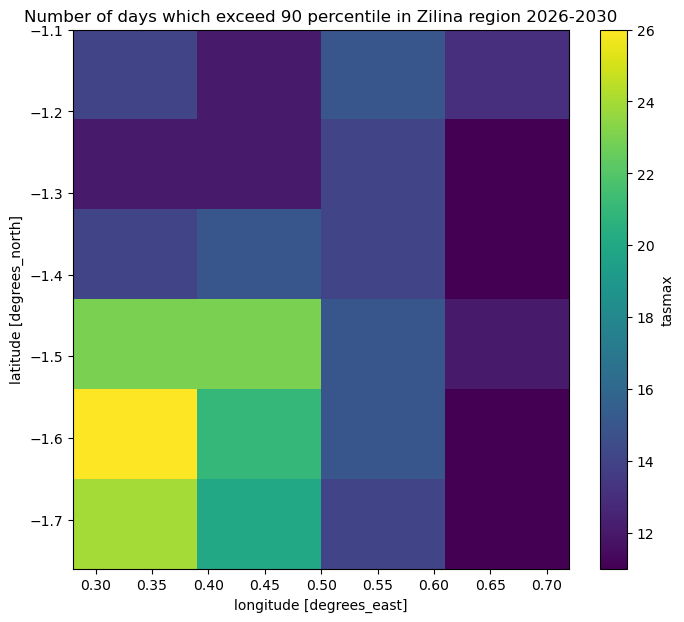

In [25]:
fig, ax=plt.subplots(figsize=(8,7))
HW.plot(ax=ax)
ax.set_title('Number of days which exceed 90 percentile in Zilina region 2026-2030')

Sum of the days which exceed 90 percentile (30 deg from Zilina) in EU 2026-2040

In [26]:
HW_EU=np.sum(heatjulZAEU,axis = 0)
HW_EU

<xarray.DataArray 'tasmax' (rlat: 412, rlon: 424)>
array([[155, 155, 155, ..., 155, 155, 155],
       [155, 155, 155, ..., 155, 154, 155],
       [155, 155, 155, ..., 154, 154, 155],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])
Coordinates:
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.73 21.83
  * rlon                        (rlon) float64 -28.38 -28.26 ... 18.05 18.16
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
    spatial_ref                 int32 0
    quantile                    float64 0.9

Text(0.5, 1.0, 'Heat-wave days in EU region 2026-2030 with Zilina treshold')

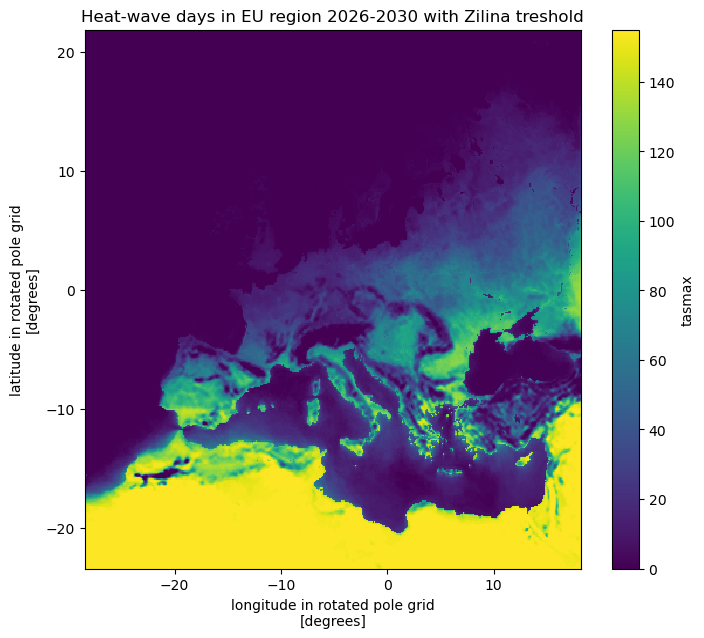

In [27]:
fig, ax=plt.subplots(figsize=(8,7))
HW_EU.plot(ax=ax)
ax.set_title('Heat-wave days in EU region 2026-2030 with Zilina treshold')

# Heat-wave events in pilot site (Zilina) in 2026-2030

In [28]:
# Create + time dataset
vt=heatZA
vt1=heatZA[:-1,:,:]
vt2=heatZA[:-2,:,:]
vt3=heatZA[:-3,:,:]
# Create missing days
tt1=heatZA[0:1,:,:]
tt2=heatZA[0:2,:,:]
tt3=heatZA[0:3,:,:]
# Concatenate missing dates to + time dataset
vit1=xr.concat([tt1, vt1], dim='time')
vit2=xr.concat([tt2, vt2], dim='time')
vit3=xr.concat([tt3, vt3], dim='time')
# Change the time dimesion for correct one
tti=heatZA["time"]
# add a time dimension
vit1["time"]=tti
vit2["time"]=tti
vit3["time"]=tti

In [29]:
# Sum of the Heat-Wave
sumvt=xr.where((vt==1)&(vit1==1)&(vit2==1), 1, 0) # count 3 day HW
sumvt2=xr.where((vt==1)&(vit1==1)&(vit2==1)&(vit3==1), -1, 0) # delete 4 and more day, it is need to be done because we need to countthe HW as 1
HWat1=sumvt.sum(dim='time')
HWat2=sumvt2.sum(dim='time')
HWt=HWat1+HWat2


Text(0.5, 1.0, 'Heat-wave events in Zilina region 2026-2030 90percentile')

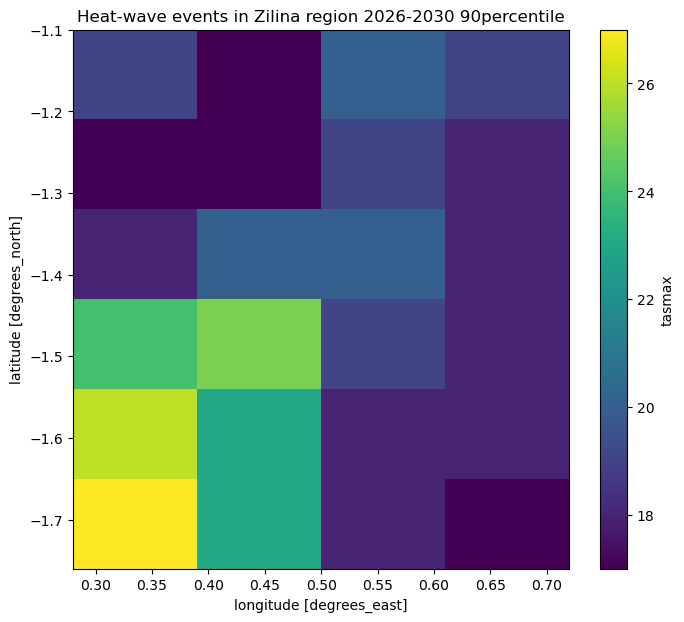

In [30]:
fig, ax=plt.subplots(figsize=(8,7))
HWt.plot(ax=ax)
ax.set_title('Heat-wave events in Zilina region 2026-2030 90percentile')

In [ ]:
HWt.rio.write_crs(rotated_pole, inplace=True)
HWt.to_netcdf(path='C:/Work/KAJO/CLIMAAX/GitHub/Cordex_HW_ZA_26_40.nc', mode='w', format='NETCDF4')

# Heat-wave events number in pilot site (Zilina) for specific month

We duplicate the original dataset and move it for 3 days + 1 extra day for the correction. 
1. Copy of the orifinal data ale shift in the time for 3 consecutive days
2. Sum of the Heat-Wave events and plot
3. Write of the CRS and Save

In [31]:
# Create + time dataset
v=heatjulZA
v1=heatjulZA[:-1,:,:]
v2=heatjulZA[:-2,:,:]
v3=heatjulZA[:-3,:,:]
# Create missing days
t1=heatjulZA[0:1,:,:]
t2=heatjulZA[0:2,:,:]
t3=heatjulZA[0:3,:,:]
# Concatenate missing dates to + time dataset
vi1=xr.concat([t1, v1], dim='time')
vi2=xr.concat([t2, v2], dim='time')
vi3=xr.concat([t3, v3], dim='time')
# Change the time dimesion for correct one
ti=heatjulZA["time"]
# add a time dimension
vi1["time"]=ti
vi2["time"]=ti
vi3["time"]=ti

In [33]:
# Sum of the Heat-Wave
sumv=xr.where((v==1)&(vi1==1)&(vi2==1), 1, 0) # count 3 day HW
sumv2=xr.where((v==1)&(vi1==1)&(vi2==1)&(vi3==1), -1, 0) # delete 4 and more day, it is need to be done because we need to countthe HW as 1
HWa1=sumv.sum(dim='time')
HWa2=sumv2.sum(dim='time')
HWa=HWa1+HWa2
#pcolormesh(HWa);colorbar();title('Heat-Waves events Zilna');show() # let us view the map...

Text(0.5, 1.0, 'Heat-wave days in EU region 2026-2030 with Zilina treshold')

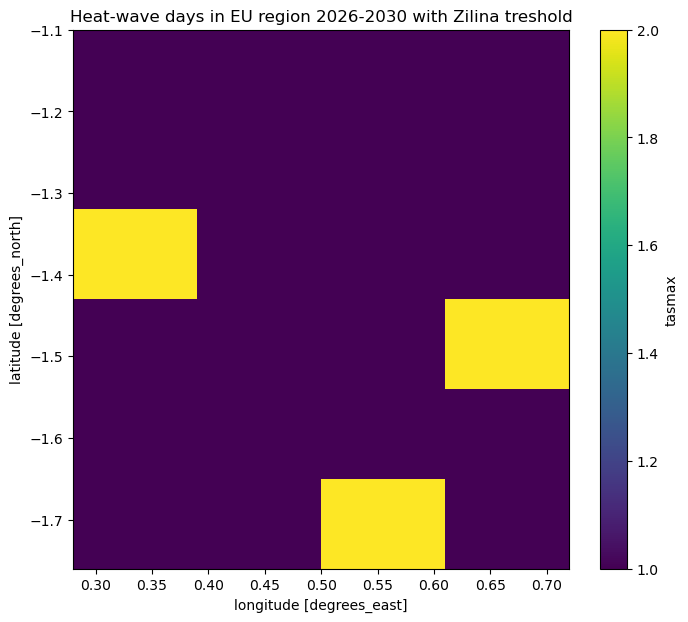

In [34]:
fig, ax=plt.subplots(figsize=(8,7))
HWa.plot(ax=ax)
ax.set_title('Number of Heat-wave events in Zilina July 2026-2030')

#### Write CRS and save  

In [35]:
HWa.rio.write_crs(rotated_pole, inplace=True)
HWa.to_netcdf(path='C:/Work/KAJO/CLIMAAX/GitHub/Cordex_HW_ZA_26_40.nc', mode='w', format='NETCDF4')

# Heat-Waves packages thermofeel, xclim, hotspell  



Thermofeel, xclim, hotspell are the packages which should be suitable for the extraction of the heat-wave events.  https://pypi.org/project/thermofeel/

In [ ]:
## https://pypi.org/project/thermofeel/ 
## https://xclim.readthedocs.io/en/stable/indices.html ### few components not working 
## https://hotspell.readthedocs.io/en/latest/   ## works with the csv
from __future__ import annotations

import xarray as xr

import xclim
from xclim import testing

xclim.indices.hot_spell_frequency(tasmax, thresh='30 degC', thresh_tasmax='UNSET', window=3, freq='YS', op='>', resample_before_rl=True)[source]
Hot spell frequency.


In [ ]:
# Imports for xclim and xarray
from __future__ import annotations

import xarray as xr

import xclim

xr.set_options(display_style="html")

import tempfile

# File handling libraries
import time
from pathlib import Path

# Output folder
#output_folder = Path(tempfile.mkdtemp())

In [ ]:
gdd = xclim.atmos.growing_degree_days(tas=dmax.tasmax, thresh="10.0 degC", freq="YS")
gdd

In [ ]:
from __future__ import annotations

import xarray as xr

import xclim
from xclim.core.units import convert_units_to, declare_units


In [ ]:
#xclim.indicators.atmos.heat_wave_index(tasmax='tasmax', *, thresh='25.0 degC', window=5, freq='YS', op='>', resample_before_rl=True, ds=None)
xclim.indicators.atmos.heat_wave_index(jul_maxZA,*, thresh='25.0 degC', window=5, freq='YS', op='>', resample_before_rl=True, ds=None)

In [ ]:
HW2=xclim.indices.hot_spell_frequency(jul, thresh='30 degC', window=3, freq='YS', op='>', resample_before_rl=True)

# Downscaling and historical data for the Heat-islands

Cordex data (0.1 deg) are not enough for the city heat islands. 
We need to agree on the way that we choose for downscaling:
- based on the elevation?
- based on the land use?
- based on the vegetation and drought characteristics?

Data:
- Eurocordex climatic data for 2m air temperature 2026-2041 ... 2100? and instrumental preiod 2016-2020 (11km spatial; 1day temporal) ### CDS API
- Sentinel2 data for Vegetation characteristics (10-20m spatial; 5-10 days temporal) (NDVI, NDWI, LAI, NDDI, NDBI) ### https://dataspace.copernicus.eu/browser/?zoom=3&lat=26&lng=0&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2Fa91f72b5-f393-4320-bc0f-990129bd9e63&datasetId=S2_L2A_CDAS&demSource3D=%22MAPZEN%22&cloudCoverage=30
- Landsat8 land surface temperature for the 2016-2020 (15-30m spatial; 8-16 days tremporal) ### https://rslab.gr/downloads_LandsatLST.html
- CHELSA climatic data downscaled from era-5 (1km spatial; monthly values, daily values are not available) ### https://envicloud.wsl.ch/#/?prefix=chelsa%2Fchelsa_V2%2FGLOBAL%2F ### https://chelsa-climate.org/

Process:
1. With the Landsat8 (30m) data we can find the Heat-islands in Zilina city in past (done).
2. To train the E-Cordex temperature data in instrumental period for Landsat LST data (need for solution)
3. Use the patterns from instrumental period for creation of the LST maps for E-Cordex temperature projections for finer resolution (need for solution)
4. Use Sentinel2 for the computation of the Vegetation characteristics, find places suitable for the green measures NDVI, NDWI, NDDI, NDBI (done)


# Cordex Historical data 2016-2020

Cordex 2016-2020

In [ ]:
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "152800:1c6ca43d-189d-48d1-9bef-b571c3f35f34"
c = cdsapi.Client(url=URL, key=KEY)


DATADIR = 'C:\Work\KAJO\CLIMAAX\GitHub\Data_'
data= c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'domain': 'europe',
        'experiment': 'rcp_8_5',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': [
            '2m_air_temperature', 'maximum_2m_temperature_in_the_last_24_hours', 'minimum_2m_temperature_in_the_last_24_hours',
        ],
        'gcm_model': 'cnrm_cerfacs_cm5',
        'rcm_model': 'clmcom_clm_cclm4_8_17',
        'ensemble_member': 'r1i1p1',
        'start_year': '2016',
        'end_year': '2020',
        'format': 'zip',
    },
   f"{DATADIR}rcp85_daily_t2m_eurminmax_2016.zip")

<xarray.DataArray 'tas' (rlat: 6, rlon: 4)>
array([[17.496992, 17.04221 , 16.446138, 15.95146 ],
       [17.64502 , 17.353935, 16.626848, 16.02452 ],
       [17.37311 , 17.336601, 16.743086, 16.130896],
       [16.69789 , 16.877625, 16.622766, 16.03799 ],
       [16.35152 , 16.45311 , 16.532738, 16.090843],
       [16.980732, 16.698225, 16.726221, 16.456444]], dtype=float32)
Coordinates:
  * rlat                        (rlat) float64 -1.705 -1.595 ... -1.265 -1.155
  * rlon                        (rlon) float64 0.335 0.445 0.555 0.665
    rotated_latitude_longitude  int32 ...
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
    height                      float64 ...
    month                       int64 7
    spatial_ref                 int32 0
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    comment:           daily-mean near-surface (usually, 2 meter) air tempera...
    units:             °C
    cell_methods:      time: mean
    associated_files:  gridspecFile: gridspec_atmos_fx_CLMcom-CCLM4-8-17_rcp8...

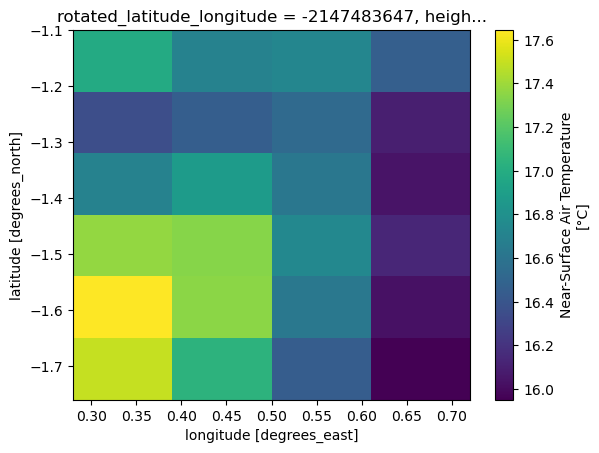

In [36]:
th='C:/Work/KAJO/CLIMAAX/GitHub/Data_rcp85_daily_t2m_eurminmax_2016/tas_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20160101-20201231.nc'
dh= xr.open_dataset(th, decode_coords="all")
dh=dh['tas']
tash=dh - 273.15
tash=tash.assign_attrs(dh.attrs)
tash.attrs['units']='°C'
H_monthly_mean = tash.groupby('time.month').mean(keep_attrs=True)
#H_monthly_mean[0,:,:].plot()
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
H_monthly_mean.rio.write_crs(rotated_pole, inplace=True)
HtasZA = H_monthly_mean.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
#HtasZA.to_netcdf(path='C:/Work/KAJO/CLIMAAX/GitHub/EC_jul_maxSK.nc', mode='w', format='NETCDF4')
HtasZA[6,:,:].plot()
tas_wgs84=HtasZA[6]
tas_wgs84

### Landsat 8 
for Calculation: ttps://www.youtube.com/watch?v=hd7fscNTff4
for Download: https://rslab.gr/downloads_LandsatLST.html

Text(0.5, 1.0, 'Landsat8 LST')

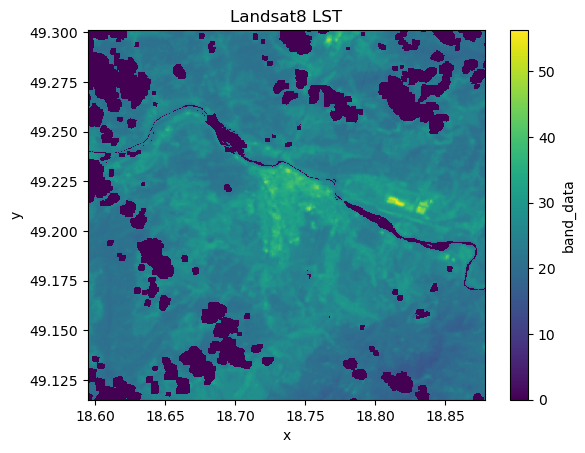

In [41]:
Landsat8='C:/Work/KAJO/CLIMAAX/Eurocordex/20160721_LS8.tif'
LS8 = xr.open_dataset(Landsat8)
LS=LS8['band_data']
LS.plot()
plt.title('Landsat8 LST')

In [39]:
HtasZA.rio.to_raster(raster_path='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/ECZA.tif')
LS.rio.to_raster(raster_path='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/LSZA.tif')

# Reproject Sentinel (S2), Cordex (EC) and Chelsa (CH) to Landsat (LS)

### Landsat 8, July 2016 land surface temperature 8 days composite

In [42]:
ls='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Landsat8.nc'
LS= xr.open_dataset(ls, decode_coords="all")
LS=LS['band_data']
#LS.plot()

Text(0.5, 1.0, 'Landsat8 LST July 2016')

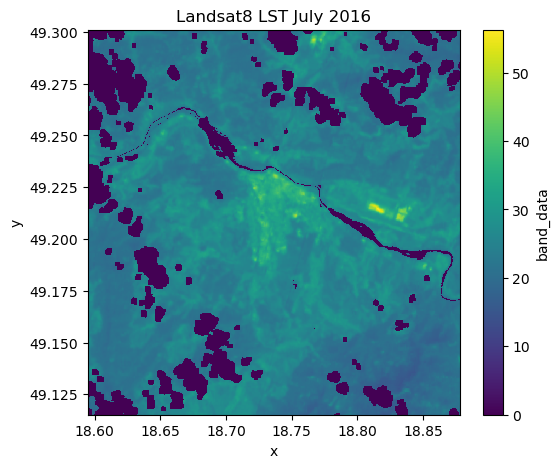

In [44]:
fig, ax=plt.subplots(figsize=(6,5))
LS.plot(ax=ax)
ax.set_title('Landsat8 LST July 2016')

### Sentinel 2, July 2016 spectral band  5 days composite

In [45]:
S2list = glob( "C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/*.jp2")
#
with rasterio.open(S2list[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(S2list))
#
with rasterio.open('C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(S2list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))
#
S2jul2016='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/raster_stack.tif'
S2jul16 = xr.open_dataset(S2jul2016)
S2=S2jul16['band_data']

In [ ]:
S2

In [46]:
B1=S2[0]
B2=S2[1]
B3=S2[2]
B4=S2[3]
B5=S2[4]
B6=S2[5]
B7=S2[6]
B8=S2[7]
B9=S2[8]
B10=S2[9]
B11=S2[10]
B12=S2[11]

In [47]:
NDVI=(B8-B4)/(B8+B4)
#NDVI.plot()
NDVI.rio.write_crs("epsg:32633", inplace=True)

<xarray.DataArray 'band_data' (y: 1830, x: 1830)>
array([[ 0.41843137,  0.3242519 ,  0.22710909, ...,  0.42290655,
         0.48683247,  0.48173517],
       [ 0.35447437,  0.34070307,  0.32236442, ...,  0.51062745,
         0.53695226,  0.38261464],
       [ 0.36077586,  0.3715131 ,  0.3184181 , ...,  0.55328   ,
         0.5532206 ,  0.48546028],
       ...,
       [-0.02291476,  0.15678255,  0.3959321 , ...,  0.32764   ,
         0.12697695,  0.12724742],
       [ 0.05472637,  0.32447088,  0.46300212, ...,  0.10618769,
         0.09891492,  0.10442165],
       [ 0.19147474,  0.33264604,  0.5048773 , ...,  0.09349786,
         0.09157626,  0.11987381]], dtype=float32)
Coordinates:
  * x            (x) float64 7e+05 7e+05 7.001e+05 ... 8.097e+05 8.097e+05
  * y            (y) float64 5.5e+06 5.5e+06 5.5e+06 ... 5.39e+06 5.39e+06
    spatial_ref  int32 0

In [48]:
S2_NDVI=NDVI.copy()

In [49]:
S2NDVI84=S2_NDVI.rio.reproject_match(LS)

Text(0.5, 1.0, 'Sentinel2 NDVI for July 2016')

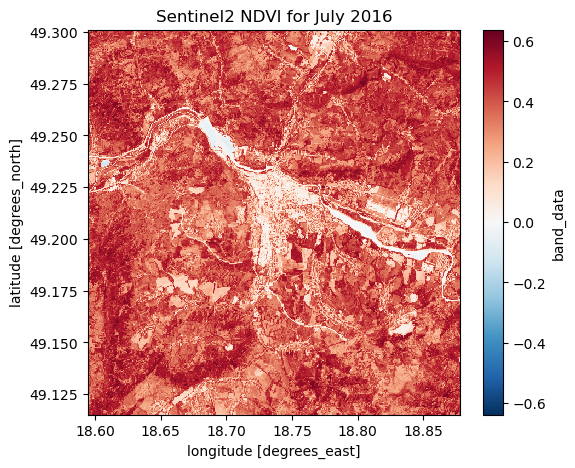

In [50]:
fig, ax=plt.subplots(figsize=(6,5))
S2NDVI84.plot(ax=ax)
ax.set_title('Sentinel2 NDVI for July 2016')

### Euro-Cordex, July 2016 max mean daily air temperature  

In [51]:
##############################################################################
# Cordex maximum daily air temperature 2016-2020 
ecmax='C:/Work/KAJO/CLIMAAX/GitHub/Data_rcp85_daily_t2m_eurminmax_2016/tasmax_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_day_20160101-20201231.nc'
#EC= xr.open_dataset(ec, decode_coords="all")
daECmax= xr.open_dataset(ecmax, decode_coords="all")
dECmax=daECmax['tasmax']
tECmax=dECmax -273.15
tECmax=tECmax.assign_attrs(daECmax.attrs)
tECmax.attrs['units']='°C'
ECmax=tECmax.groupby('time.month').mean(keep_attrs=True)
ECmax=ECmax[6]

In [52]:
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
ECmax.rio.write_crs(rotated_pole, inplace=True)
ECmaxZA = ECmax.rio.clip_box(minx=0.3, miny=-1.7, maxx=0.7, maxy=-1.2,)
ECmaxZA.rio.to_raster(raster_path='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/ECmaxZA.tif')
#ECmaxZA.plot()

Text(0.5, 1.0, 'Cordex Tmax mean July 2016-2020')

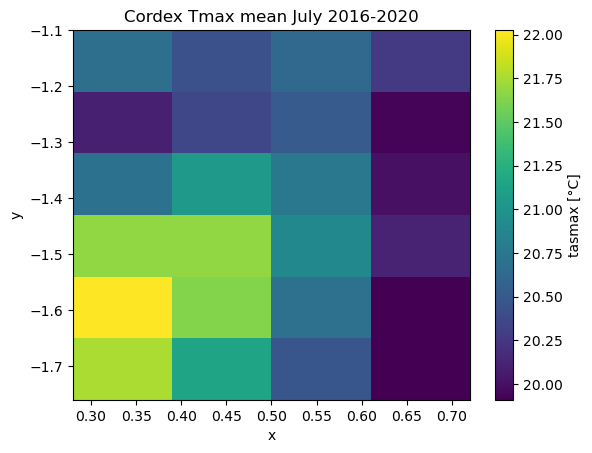

In [54]:
ec='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/ECmaxZA.tif'
#EC= xr.open_dataset(ec, decode_coords="all")
EC= xr.open_dataset(ec)
EC=EC['band_data']
EC=EC[0]
EC.plot()
plt.title('Cordex Tmax mean July 2016-2020')

In [55]:
EC3=EC.copy()
ECmax84=EC3.rio.reproject_match(LS)

Text(0.5, 1.0, 'Crodex Tmax mean for July 2016')

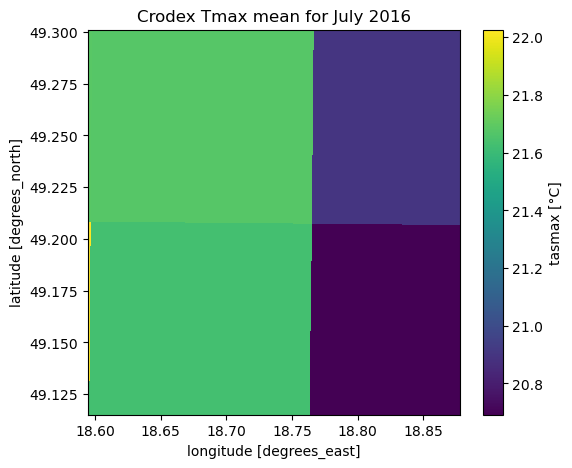

In [54]:
#fig, ax=plt.subplots(figsize=(6,5))
#ECmax84.plot(ax=ax)
#ax.set_title('Crodex Tmax mean for July 2016')

In [ ]:
ECmax84.rio.bounds()

In [ ]:
#########################################################################################################

Rename of the rlat rlon indexes or load of the .tif file 

In [ ]:
#EC2=EC2.rename({'rlon':'x', 'rlat':'y'})

### Chelsea,  July 2016 max mean daily air temperature   

In [56]:
# load of the Chelsa data 
#https://envicloud.wsl.ch/#/?prefix=chelsa%2Fchelsa_V2%2FGLOBAL%2F
ch='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/CHELSA_tasmax_07_2016_V.2.1.tif'
#EC= xr.open_dataset(ec, decode_coords="all")
CH= xr.open_dataset(ch)
CH=CH['band_data']
#CH.plot()
CH=CH[0]
# (18.59485688668886, 49.1151186646496, 18.87809569577174, 49.30106992846235)
CHZA = CH.rio.clip_box(minx=18.59485688668886, miny=49.1151186646496, maxx=18.87809569577174, maxy=49.30106992846235)
CHZA=(CHZA/10) - 273.15
#CHZA.plot()

In [57]:
# Chelsa data reproject to Landsat
CHZA84=CHZA.rio.reproject_match(LS)

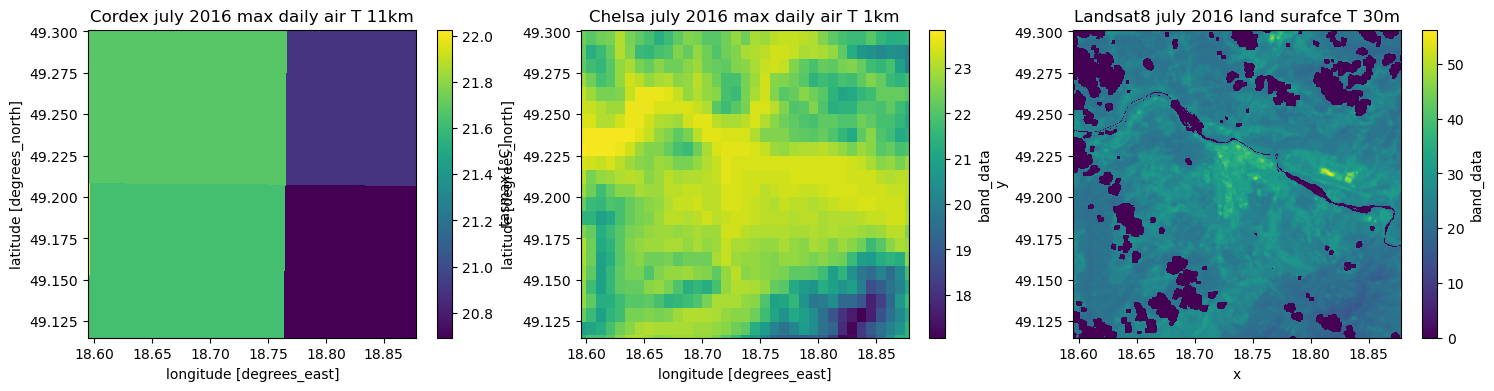

In [58]:
# Plot Cordex, Chelsa, Landsat
fig, axes=plt.subplots(ncols=3, figsize=(18,4))
ECmax84.plot(ax=axes[0])
axes[0].set_title('Cordex july 2016 max daily air T 11km')
CHZA84.plot(ax=axes[1])
axes[1].set_title('Chelsa july 2016 max daily air T 1km')
LS.plot(ax=axes[2])
axes[2].set_title('Landsat8 july 2016 land surafce T 30m')
plt.draw()

Text(0.5, 1.0, 'Sentinel2 NDVI july 2016 10m')

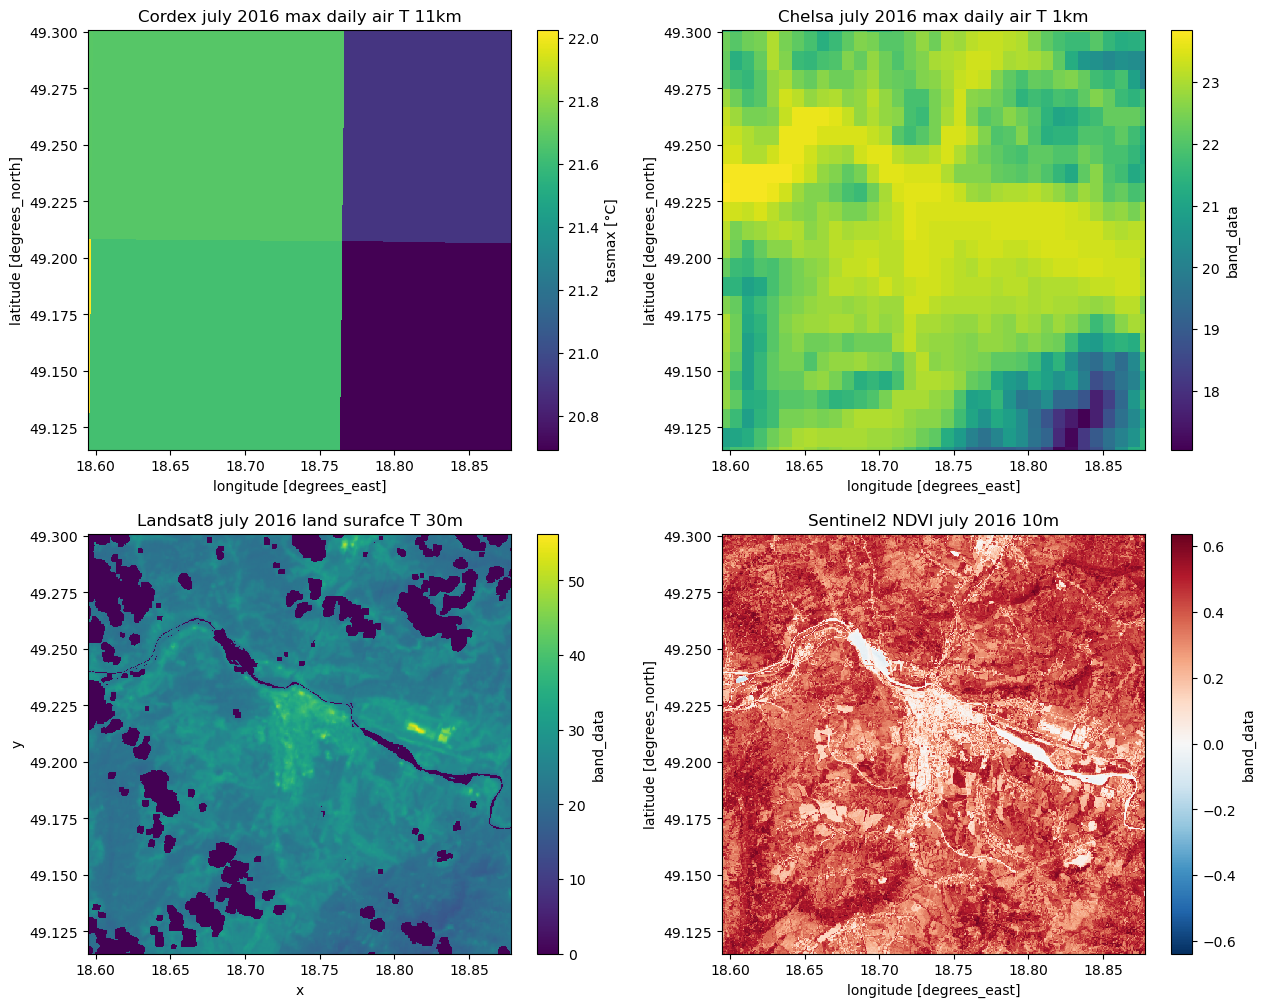

In [62]:
# Plot Cordex, Chelsa, Landsat
fig, axes=plt.subplots(ncols=2, nrows=2, figsize=(15,12))
ECmax84.plot(ax=axes[0,0])
axes[0,0].set_title('Cordex july 2016 max daily air T 11km')
#CI_WGS.plot(ax=axes[0,0], color='red')
CHZA84.plot(ax=axes[0,1])
axes[0,1].set_title('Chelsa july 2016 max daily air T 1km')
#CI_WGS.plot(ax=axes[0,1], color='red')
LS.plot(ax=axes[1,0])
axes[1,0].set_title('Landsat8 july 2016 land surafce T 30m')
#CI_WGS.plot(ax=axes[1,0], color='red')
S2NDVI84.plot(ax=axes[1,1])
axes[1,1].set_title('Sentinel2 NDVI july 2016 10m')
#CI_WGS.plot(ax=axes[1,1], color='green')

# Critical infrastructure in Zilina 

In [63]:
ci='C:/Work/KAJO/CLIMAAX/Zilina/Zilina_Data/ci_features_ZA/ci_features_ZA.shp'
CI=gpd.read_file(ci)

<Axes: >

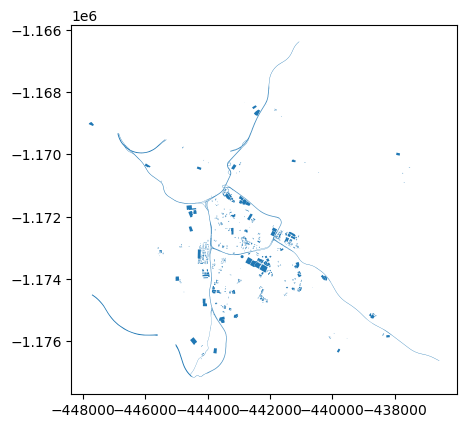

In [64]:
CI.plot()

In [65]:
CI

class                                              label relation  \
0         sport                          Futbalové ihrisko Bytčica       no   
1         sport                                      Zimný štadión      yes   
2         sport                 Mestská krytá plaváreň a kúpalisko      yes   
3        social                 Denné centrum – Nám. J. Borodáča 1      yes   
4        social            Denný stacionár, Námestie J. Borodáča 1      yes   
..          ...                                                ...      ...   
217       sport                        Bežecká dráha Bôrická cesta       no   
218   education  Súkromná škola umeleckého priemyslu, Hálkova, ...       no   
219      health  MONERE s.r.o. Výdajňa zdravotníckych pomôcok, ...       no   
220       sport                           Futbalové ihrisko Vranie       no   
221  industrial                              Metsa Tissue Slovakia       no   

     capacity                              Note  ID_num  \
0           0                               NaN       1   
1        5500  údávané rôzne kapacity, max 6200       2   
2        3000        kapacita je pre celý areál       3   
3           0                               NaN       4   
4           0                               NaN       5   
..        ...                               ...     ...   
217         0                               NaN     221   
218         0                               NaN     222   
219         0                               NaN     223   
220         0                               NaN     224   
221       500                               NaN     225   

                                              geometry  
0    POLYGON ((-443791.900 -1176223.690, -443725.72...  
1    POLYGON ((-442944.823 -1171479.266, -442944.54...  
2    POLYGON ((-442605.270 -1173354.650, -442602.57...  
3    POLYGON ((-441750.800 -1173434.590, -441738.31...  
4    POLYGON ((-441730.410 -1173442.360, -441720.21...  
..                                                 ...  
217  POLYGON ((-443190.610 -1174360.630, -443143.59...  
218  POLYGON ((-443770.798 -1172424.961, -443770.65...  
219  POLYGON ((-442807.238 -1172005.861, -442811.73...  
220  POLYGON ((-442437.440 -1168488.120, -442529.92...  
221  MULTIPOLYGON (((-441033.248 -1173037.741, -441...  

[222 rows x 7 columns]

In [ ]:
#https://spatialreference.org/
CI.crs

In [ ]:
CI.geometry[:5]

In [66]:
CI_WGS=CI.to_crs(epsg=4326)

In [ ]:
CI_WGS.plot()

Text(0.5, 1.0, 'Landsat8 LST with critical infrastructure')

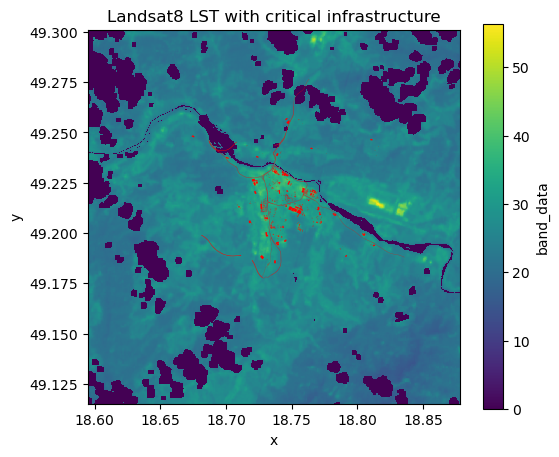

In [67]:
fig, ax=plt.subplots(figsize=(6,5))
LS.plot(ax=ax)
CI_WGS.plot(ax=ax, color='red')
ax.set_title('Landsat8 LST with critical infrastructure')


<Axes: title={'center': 'Sentinel2 NDVI july 2016 10m'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

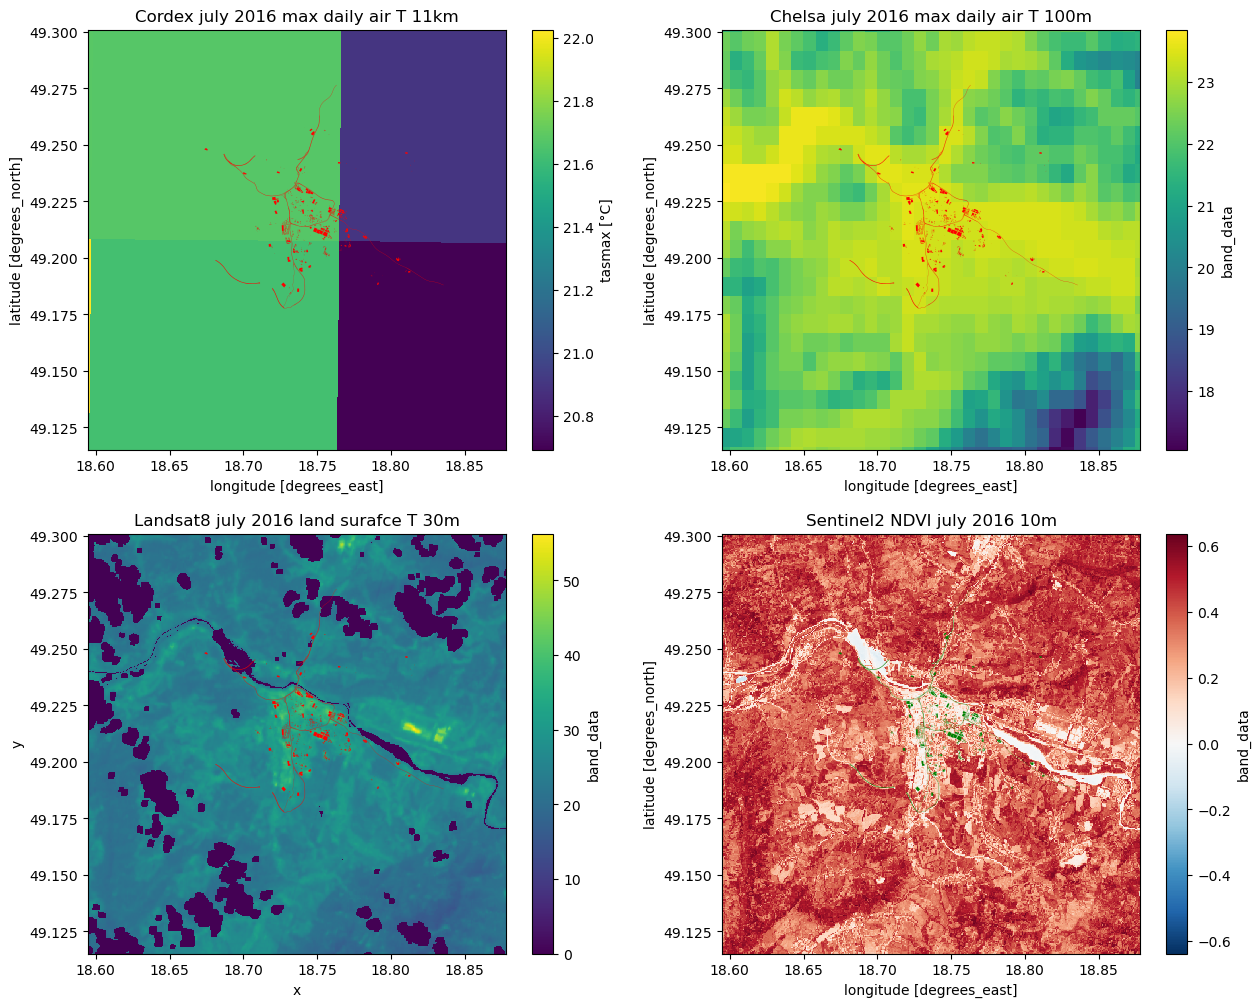

In [68]:
# Plot Cordex, Chelsa, Landsat
fig, axes=plt.subplots(ncols=2, nrows=2, figsize=(15,12))
ECmax84.plot(ax=axes[0,0])
axes[0,0].set_title('Cordex july 2016 max daily air T 11km')
CI_WGS.plot(ax=axes[0,0], color='red')
CHZA84.plot(ax=axes[0,1])
axes[0,1].set_title('Chelsa july 2016 max daily air T 100m')
CI_WGS.plot(ax=axes[0,1], color='red')
LS.plot(ax=axes[1,0])
axes[1,0].set_title('Landsat8 july 2016 land surafce T 30m')
CI_WGS.plot(ax=axes[1,0], color='red')
S2NDVI84.plot(ax=axes[1,1])
axes[1,1].set_title('Sentinel2 NDVI july 2016 10m')
CI_WGS.plot(ax=axes[1,1], color='green')

# Heat islands from Landsat 8 2016-2020

In [ ]:
#da_m=dm['tas']
#tas=da_m -273.15
#tas=tas.assign_attrs(da_m.attrs)
#tas.attrs['units']='°C'
#monthly_mean = tas.groupby('time.month').mean(keep_attrs=True)
#monthly_mean[0,:,:].plot()

In [69]:
Landsat8jun='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Landsat8/LS8_jun_2016_2020.tif'
LSjun = xr.open_dataset(Landsat8jun)
LSjun=LSjun['band_data']
#LS.plot()
LSjunmax=LSjun.max(dim='band', skipna=True,  keep_attrs=True)
#LSjunmax

<xarray.DataArray 'band_data' (y: 462, x: 659)>
array([[27.86710066, 28.34517261, 28.51018776, ..., 27.55912974,
        27.98489988, 28.02758083],
       [28.034064  , 27.73186189, 27.79595645, ..., 29.47822247,
        29.80123467, 29.70660094],
       [27.90148611, 27.6000312 , 27.53582958, ..., 30.26756291,
        30.71219887, 30.62281699],
       ...,
       [27.81061403, 27.42689041, 27.18583755, ..., 23.17835871,
        23.18885205, 23.60537908],
       [27.38013484, 26.86968585, 26.72024041, ..., 23.24475271,
        23.22376974, 23.62292533],
       [26.84784649, 26.71914124, 26.71914124, ..., 23.04134342,
        23.02048922, 23.31475944]])
Coordinates:
  * x            (x) float64 18.64 18.64 18.64 18.64 ... 18.82 18.82 18.82 18.82
  * y            (y) float64 49.28 49.28 49.28 49.28 ... 49.16 49.16 49.16 49.16
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        49.067242008307
    STATISTICS_MEAN:           11.15951144728
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         12.108106299495
    STATISTICS_VALID_PERCENT:  100

In [70]:
Landsat8jul='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Landsat8/LS8_jul_2016_2020.tif'
LSjul = xr.open_dataset(Landsat8jul)
LSjul=LSjul['band_data']
#LS.plot()
LSjulmax=LSjul.max(dim='band', skipna=True,  keep_attrs=True)
#LSjulmax

<xarray.DataArray 'band_data' (y: 462, x: 659)>
array([[28.86216182, 29.49676344, 29.43995298, ..., 28.08938872,
        28.20463234, 28.26067171],
       [29.21050208, 28.73805346, 28.60531623, ..., 29.58932746,
        29.83149071, 29.71558246],
       [29.15383576, 28.62791265, 28.4752773 , ..., 30.34808105,
        30.80946219, 30.69228301],
       ...,
       [28.37830717, 27.74221047, 27.51945972, ..., 23.39338502,
        23.42854252, 23.80260276],
       [27.81945055, 27.06015996, 26.7856705 , ..., 23.2995812 ,
        23.2995812 , 23.74667656],
       [27.0811853 , 27.16603754, 27.16603754, ..., 23.10048848,
        23.10048848, 23.4223732 ]])
Coordinates:
  * x            (x) float64 18.64 18.64 18.64 18.64 ... 18.82 18.82 18.82 18.82
  * y            (y) float64 49.28 49.28 49.28 49.28 ... 49.16 49.16 49.16 49.16
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        51.349931503241
    STATISTICS_MEAN:           16.630099424645
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         12.968232957118
    STATISTICS_VALID_PERCENT:  100

In [71]:
Landsat8aug='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Landsat8/LS8_aug_2016_2020.tif'
LSaug = xr.open_dataset(Landsat8aug)
LSaug=LSaug['band_data']
#LS.plot()
LSaugmax=LSaug.max(dim='band', skipna=True,  keep_attrs=True)
#LSaugmax

<xarray.DataArray 'band_data' (y: 462, x: 659)>
array([[30.92126678, 31.39924971, 31.53530983, ..., 31.2883534 ,
        31.28475818, 31.32763998],
       [31.08113613, 30.91397569, 30.90668784, ..., 32.73120009,
        32.87224721, 32.78275312],
       [31.06277886, 30.79000841, 30.65492722, ..., 33.10340443,
        33.57536636, 33.48471579],
       ...,
       [30.45396963, 29.72090014, 29.41409259, ..., 24.94954874,
        24.93441122, 25.20040735],
       [30.38995304, 29.2494637 , 28.90121345, ..., 24.95711348,
        24.95711348, 25.21943755],
       [30.04634126, 29.35923367, 29.35923367, ..., 24.64536799,
        24.64536799, 24.84375073]])
Coordinates:
  * x            (x) float64 18.64 18.64 18.64 18.64 ... 18.82 18.82 18.82 18.82
  * y            (y) float64 49.28 49.28 49.28 49.28 ... 49.16 49.16 49.16 49.16
    spatial_ref  int32 ...
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        38.414106292881
    STATISTICS_MEAN:           1.6639872756687
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         6.0205342258494
    STATISTICS_VALID_PERCENT:  100

In [ ]:
# xr.open_mfdataset('my/files/*.nc', parallel=True)
#jun16=xr.open_mfdataset('C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Landsat8/2016/aster/jun/*.tif')

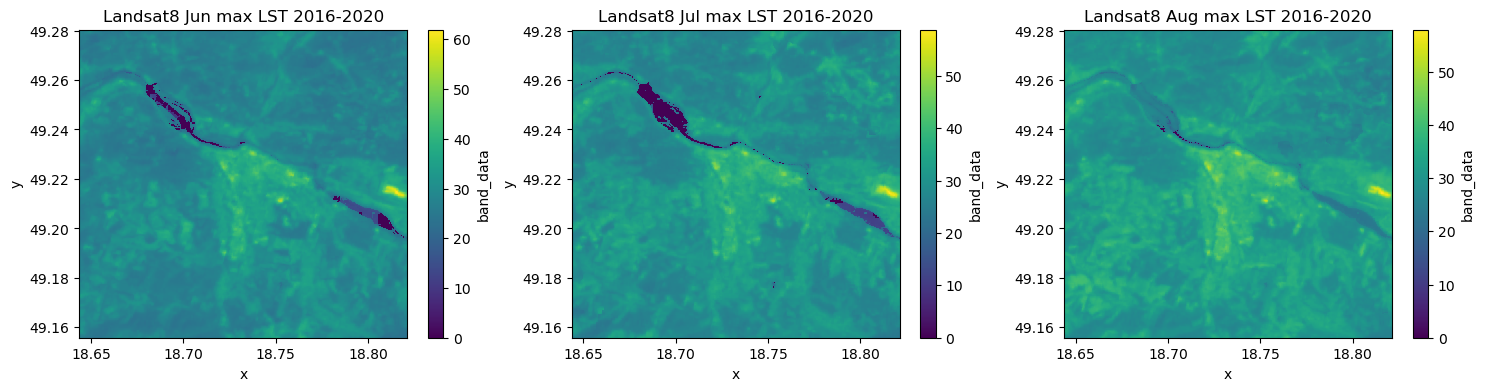

In [72]:
# Plot  Landsat
fig, axes=plt.subplots(ncols=3, figsize=(18,4))
LSjunmax.plot(ax=axes[0])
axes[0].set_title('Landsat8 Jun max LST 2016-2020')
LSjulmax.plot(ax=axes[1])
axes[1].set_title('Landsat8 Jul max LST 2016-2020')
LSaugmax.plot(ax=axes[2])
axes[2].set_title('Landsat8 Aug max LST 2016-2020')
plt.draw()

# Sentinel2 vegetation characteristics 2016-2020

- We calculated the NDVI and NDWI in 2016-2020 for summer months June, July and August 
    1. Firstly, we load of the Landsat data for the reprojection of the Sentinel2
    2. Secondly, we list the data for specific month 
    3. Thirdly, we calculate the NDVI and NDWI in the loop and save in file. We did this approach for each month 

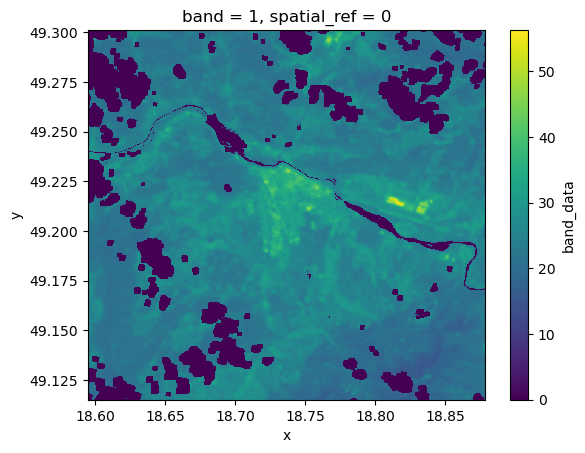

In [73]:
# Load of the landsat
ls='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Landsat8.nc'
LS= xr.open_dataset(ls, decode_coords="all")
LS=LS['band_data']
LS.plot()

June 2016-2020 computation this takes time !!!!!!!!!!!!!!!! 

In [ ]:
## JUNE
B3jun = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/R10/jun/*B03_10m.jp2")
B4jun = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/R10/jun/*B04_10m.jp2")
B8jun = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/R10/jun/*B08_10m.jp2")

In [ ]:
## JUNE
for i in range(7):
    B3p=B3jun[i]
    B4p=B4jun[i]
    B8p=B8jun[i]
    
    B3=xr.open_dataset(B3p)
    B3=B3['band_data']
    
    B4=xr.open_dataset(B4p)
    B4=B4['band_data']
    
    B8=xr.open_dataset(B8p)
    B8=B8['band_data']
    
    NDVI=(B8-B4)/(B8+B4)
    NDWI=(B3-B8)/(B3+B8)
    
    #NDVI.rio.write_crs("epsg:32633", inplace=True)
    
    NDVI84=NDVI.rio.reproject_match(LS)
    NDWI84=NDWI.rio.reproject_match(LS)
    
    p=Path(B4jun[i])
    # https://peps.python.org/pep-0428/
    x=str(p.stem)
    
    NDVI84.rio.to_raster(raster_path='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/NDVI_JUN'+ x +'.tif') 
    NDWI84.rio.to_raster(raster_path='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/NDWI_JUN'+ x +'.tif')
   

In [ ]:
NDVI84.plot()

July 2016-2020 computation this takes time !!!!!!!!!!!!!!!!

In [ ]:
## JULY
B3jul = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/R10/jul/*B03_10m.jp2")
B4jul = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/R10/jul/*B04_10m.jp2")
B8jul = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/R10/jul/*B08_10m.jp2")

In [ ]:
## JULY
for i in range(8):
    B3p=B3jul[i]
    B4p=B4jul[i]
    B8p=B8jul[i]
    
    B3=xr.open_dataset(B3p)
    B3=B3['band_data']
    
    B4=xr.open_dataset(B4p)
    B4=B4['band_data']
    
    B8=xr.open_dataset(B8p)
    B8=B8['band_data']
    
    NDVI=(B8-B4)/(B8+B4)
    NDWI=(B3-B8)/(B3+B8)
    
    #NDVI.rio.write_crs("epsg:32633", inplace=True)
    
    NDVI84=NDVI.rio.reproject_match(LS)
    NDWI84=NDWI.rio.reproject_match(LS)
    
    p=Path(B4jul[i])
    # https://peps.python.org/pep-0428/
    x=str(p.stem)
    
    NDVI84.rio.to_raster(raster_path='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/NDVI_JUL'+ x +'.tif') 
    NDWI84.rio.to_raster(raster_path='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/NDWI_JUL'+ x +'.tif')

August 2016-2020 computation this takes time !!!!!!!!!!!!!!!! 

In [ ]:
## August
B3aug = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/R10/aug/*B03_10m.jp2")
B4aug = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/R10/aug/*B04_10m.jp2")
B8aug = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/R10/aug/*B08_10m.jp2")

In [ ]:
B3aug = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/R10/aug/*B03_10m.jp2")
B4aug = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/R10/aug/*B04_10m.jp2")
B8aug = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/R10/aug/*B08_10m.jp2")
## August
for i in range(10):
    B3p=B3aug[i]
    B4p=B4aug[i]
    B8p=B8aug[i]
    
    B3=xr.open_dataset(B3p)
    B3=B3['band_data']
    
    B4=xr.open_dataset(B4p)
    B4=B4['band_data']
    
    B8=xr.open_dataset(B8p)
    B8=B8['band_data']
    
    NDVI=(B8-B4)/(B8+B4)
    NDWI=(B3-B8)/(B3+B8)
    
    #NDVI.rio.write_crs("epsg:32633", inplace=True)
    
    NDVI84=NDVI.rio.reproject_match(LS)
    NDWI84=NDWI.rio.reproject_match(LS)
    
    p=Path(B4aug[i])
    # https://peps.python.org/pep-0428/
    x=str(p.stem)
    
    NDVI84.rio.to_raster(raster_path='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/NDVI_AUG'+ x +'.tif') 
    NDWI84.rio.to_raster(raster_path='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/NDWI_AUG'+ x +'.tif')

### Average values for the June, July and August in 2016-2020

JUNE load of the data 

In [75]:
AvgNDVIjun = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/NDVI_JUN*.tif")
AvgNDVIjun

['C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JUNT33UYQ_20210616T095031_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JUNT33UYQ_20220611T095041_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JUNT33UYQ_20230601T094549_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JUNT34UCV_20160629T094032_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JUNT34UCV_20200613T094039_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JUNT34UCV_20210616T095031_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JUNT34UCV_20230601T094549_B04_10m.tif']

In [76]:
with rasterio.open(AvgNDVIjun[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(AvgNDVIjun))
#
with rasterio.open('C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/stackJun.tif','w', **meta) as dst:
    for id, layer in enumerate(AvgNDVIjun, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

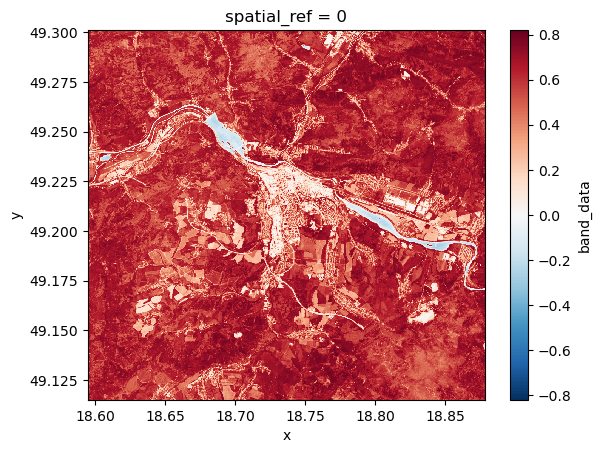

In [77]:
NDVIjun16_20='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/stackJun.tif'
NDVIjun1620 = xr.open_dataset(NDVIjun16_20)
NDVIjun16_20=NDVIjun1620.mean(dim='band', skipna=True,  keep_attrs=True)
NDVIjun16_20=NDVIjun16_20['band_data']
#NDVIjun16_20.plot()

JULY load of the data 

In [78]:
AvgNDVIjul = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/NDVI_JUL*.tif")
AvgNDVIjul

['C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JULT33UYQ_20160702T095032_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JULT33UYQ_20160722T095032_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JULT33UYQ_20170712T095029_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JULT34UCV_20170729T094029_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JULT34UCV_20180704T094029_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JULT34UCV_20190704T094041_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JULT34UCV_20200701T095031_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_JULT34UCV_20200728T094041_B04_10m.tif']

In [79]:
with rasterio.open(AvgNDVIjul[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(AvgNDVIjul))
#
with rasterio.open('C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/stackJul.tif','w', **meta) as dst:
    for id, layer in enumerate(AvgNDVIjul, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

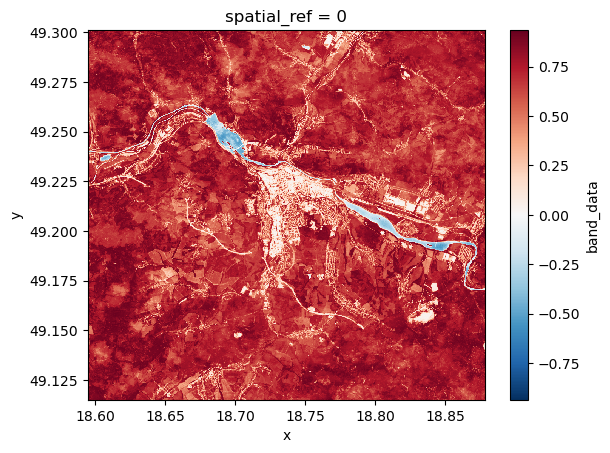

In [80]:
NDVIjul16_20='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/stackJul.tif'
NDVIjul1620 = xr.open_dataset(NDVIjul16_20)
NDVIjul16_20=NDVIjul1620.mean(dim='band', skipna=True,  keep_attrs=True)
NDVIjul16_20=NDVIjul16_20['band_data']
#NDVIjul16_20.plot()

AUGUST load of the data 

In [81]:
AvgNDVIaug = glob("C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/NDVI_AUG*.tif")
AvgNDVIaug

['C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_AUGT33UYQ_20160828T094032_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_AUGT33UYQ_20160831T095032_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_AUGT33UYQ_20170811T095029_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_AUGT33UYQ_20170831T095029_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_AUGT33UYQ_20180821T095031_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_AUGT33UYQ_20180828T094031_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_AUGT33UYQ_20200820T095041_B04_10m.tif',
 'C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI\\NDVI_AUGT34UCV_20160808T094032_B04_10m.tif',


In [82]:
with rasterio.open(AvgNDVIaug[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(AvgNDVIaug))
#
with rasterio.open('C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/stackAug.tif','w', **meta) as dst:
    for id, layer in enumerate(AvgNDVIaug, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))
#


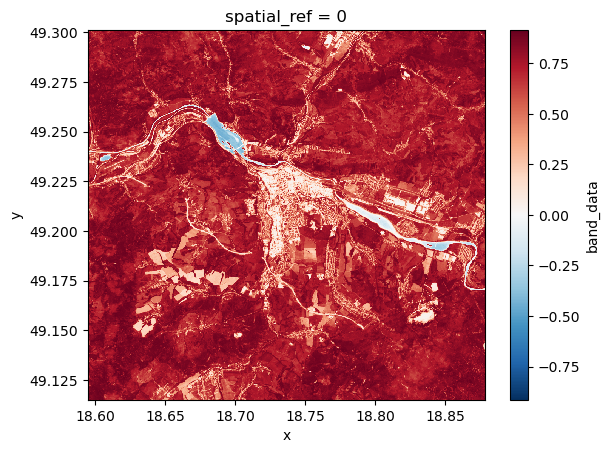

In [83]:
NDVIaug16_20='C:/Work/KAJO/CLIMAAX/GitHub/Downscale/Sentinel2/2016_2020/NDVI_LAI_NDWI_NDDI/stackAug.tif'
NDVIaug1620 = xr.open_dataset(NDVIaug16_20)
NDVIaug16_20=NDVIaug1620.mean(dim='band', skipna=True,  keep_attrs=True)
NDVIaug16_20=NDVIaug16_20['band_data']
#NDVIaug16_20.plot()

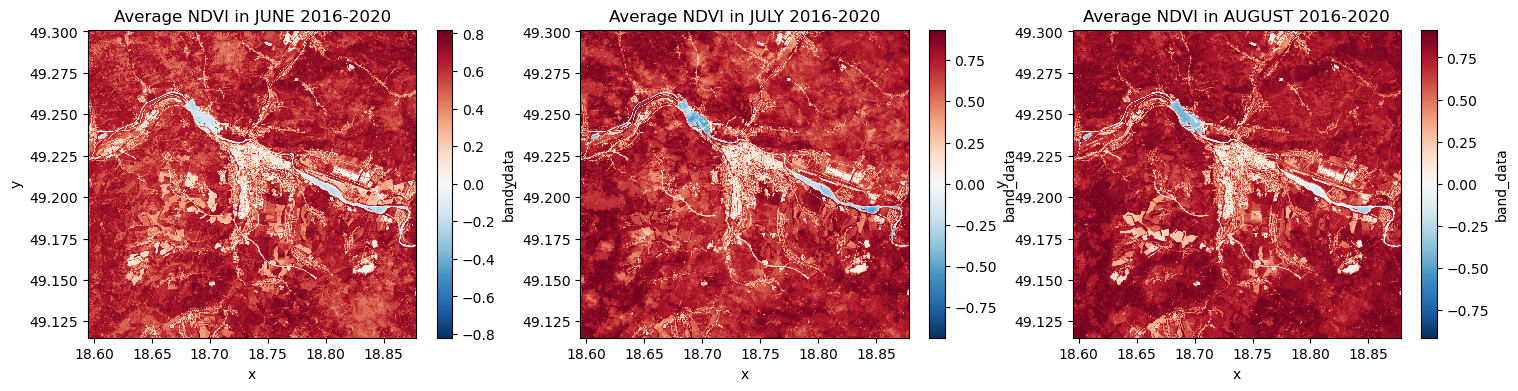

In [84]:
# plot of the NDVI for summer mounth in 2016-2020
fig, axes=plt.subplots(ncols=3, figsize=(18,4))
NDVIjun16_20.plot(ax=axes[0])
axes[0].set_title('Average NDVI in JUNE 2016-2020')
NDVIjul16_20.plot(ax=axes[1])
axes[1].set_title('Average NDVI in JULY 2016-2020')
NDVIaug16_20.plot(ax=axes[2])
axes[2].set_title('Average NDVI in AUGUST 2016-2020')
plt.draw()

### NDVI reclass 

In [85]:
## RECLASS
# NDVI 1 class -1.0 ~ 0.2 [1] Bare areas or rock, water, sand or snow, 
#               0.2 ~ 0.2 [2] Grass 
#               0.2 ~ 0.4 [3] Shrub and grassland
#               0.4 ~ 0.6 [4] Mixed Forest and Shrubs
#               0.6 ~ 0.8 [5] Forest
#               0.8 ~ 1.0 [6] Dense forest
#
# NDVI 2 class -1.0 ~ 0.0 [1] Bare areas or rock, water, sand or snow, 
#               0.0 ~ 0.2 [2] Grass 
#               0.2 ~ 0.4 [3] Shrub and grassland
#               0.4 ~ 0.6 [4] Mixed Forest and Shrubs
#               0.6 ~ 1.0 [5] Forest
#              
## JUNE
NDVIjun_bins=[-1,0, 0.2, 0.4, 0.6,0.8, 1]
NDVIjun_values=[0, 1, 2, 3, 4, 5, 6]
NDVIjun1620_class = reclassify(NDVIjun16_20, bins=NDVIjun_bins, new_values=NDVIjun_values)
#NDVIjun1620_class.plot()
## JULY
NDVIjul_bins=[-1,0, 0.2, 0.4, 0.6,0.8, 1]
NDVIjul_values=[0, 1, 2, 3, 4, 5, 6]
NDVIjul1620_class = reclassify(NDVIjul16_20, bins=NDVIjul_bins, new_values=NDVIjul_values)
#NDVIjul1620_class.plot()
## AUGUST
NDVIaug_bins=[-1,0, 0.2, 0.4, 0.6,0.8, 1]
NDVIaug_values=[0, 1, 2, 3, 4, 5, 6]
NDVIaug1620_class = reclassify(NDVIaug16_20, bins=NDVIaug_bins, new_values=NDVIaug_values)
#NDVIjun1620_class.plot()

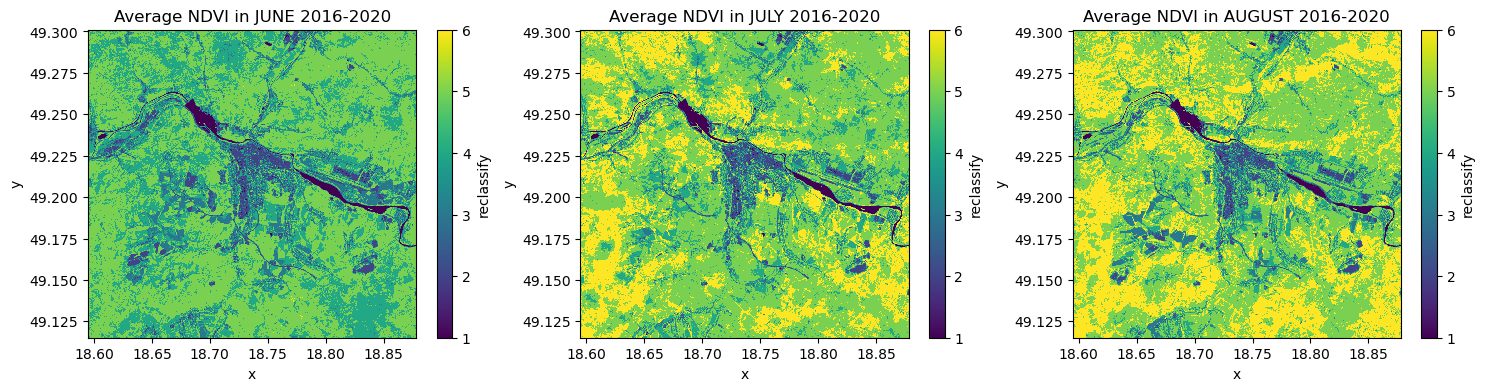

In [86]:
# plot of the NDVI for summer mounth in 2016-2020
fig, axes=plt.subplots(ncols=3, figsize=(18,4))
NDVIjun1620_class.plot(ax=axes[0])
axes[0].set_title('Average NDVI in JUNE 2016-2020')
NDVIjul1620_class.plot(ax=axes[1])
axes[1].set_title('Average NDVI in JULY 2016-2020')
NDVIaug1620_class.plot(ax=axes[2])
axes[2].set_title('Average NDVI in AUGUST 2016-2020')
plt.draw()

## Green status in city area


In [ ]:
#CHZA = CH.rio.clip_box(minx=18.59485688668886, miny=49.1151186646496, maxx=18.87809569577174, maxy=49.30106992846235)

In [97]:
# OC DUBEN 18.746848502,18.758152395,49.206861436,49.215997667 [EPSG:4326]
NDVIjun1620_City=NDVIjun1620_class.rio.clip_box(minx=18.746848502, miny=49.206861436, maxx=18.758152395, maxy=49.215997667 )
NDVIjul1620_City=NDVIjun1620_class.rio.clip_box(minx=18.73, miny=49.20, maxx=18.75, maxy=49.22)
NDVIaug1620_City=NDVIjun1620_class.rio.clip_box(minx=18.73, miny=49.20, maxx=18.75, maxy=49.22)


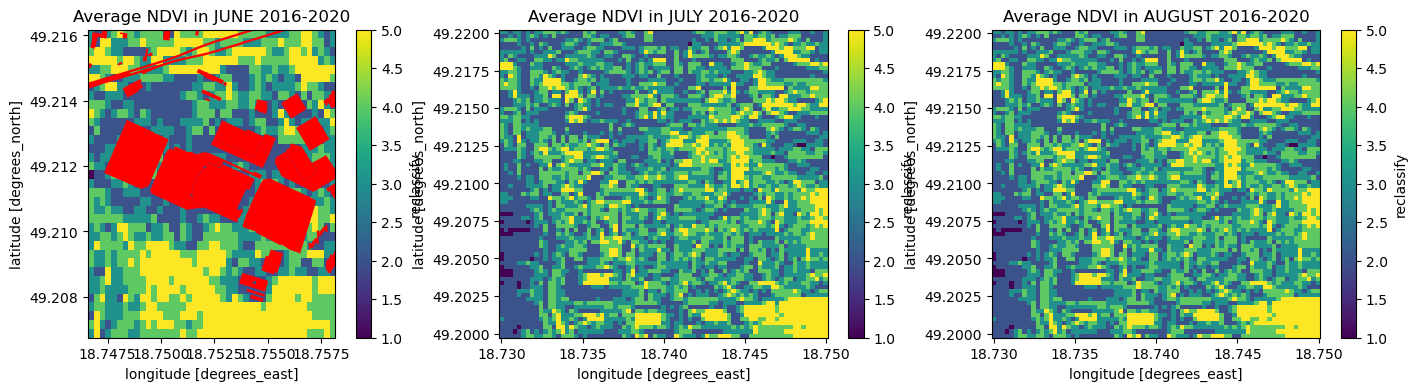

In [100]:
fig, axes=plt.subplots(ncols=3, figsize=(18,4))
NDVIjun1620_City.plot(ax=axes[0])
axes[0].set_title('Average NDVI in JUNE 2016-2020')
CI_WGS.plot(ax=axes[0], color='red')
NDVIjul1620_City.plot(ax=axes[1])
axes[1].set_title('Average NDVI in JULY 2016-2020')
NDVIaug1620_City.plot(ax=axes[2])
axes[2].set_title('Average NDVI in AUGUST 2016-2020')
plt.draw()

In [ ]:
fig, axes=plt.subplots(ncols=2, nrows=2, figsize=(15,12))
ECmax84.plot(ax=axes[0,0])
axes[0,0].set_title('Cordex july 2016 max daily air T 11km')
CI_WGS.plot(ax=axes[0,0], color='red')
CHZA84.plot(ax=axes[0,1])
axes[0,1].set_title('Chelsa july 2016 max daily air T 100m')
CI_WGS.plot(ax=axes[0,1], color='red')
LS.plot(ax=axes[1,0])
axes[1,0].set_title('Landsat8 july 2016 land surafce T 30m')
CI_WGS.plot(ax=axes[1,0], color='red')
S2NDVI84.plot(ax=axes[1,1])
axes[1,1].set_title('Sentinel2 NDVI july 2016 10m')
CI_WGS.plot(ax=axes[1,1], color='green')